# Phase Behaviors of Block Copolymers via Polyorder.jl and Related Packages - Part 2

In [2]:
import Pkg
Pkg.activate(".")

using Polymer
using Scattering
using Polyorder
import Polyorder as JP
using PhaseDiagram
using PolymerArchitectureMakie
using CairoMakie
using LaTeXStrings

  Activating project at `~/SynologyDrive/Develop/Polyorder.jl/docs/tutorial`
┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /Users/lyx/.julia/packages/FourierFlows/0jzfd/src/FourierFlows.jl:118


In [3]:
# Suppressing displaying source code file location for @info
using Logging
global_logger(ConsoleLogger())

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [4]:
include("common.jl")

plot_density (generic function with 3 methods)

Phase diagram maps equilibrium phases to the parameter space. To construct a phase diagram for microphase separation, it is sufficient to determine the phase boundary between each pair of phases. The phase boundary is determined by comparing the free energies of two phases and find the point where the free energies are equal.

## Manual construction

Use batch evaluations to obtain free energies for both phases as in the User Guide Part1 for LAM and HEX. Then find the cross point of the two free energy curves, which corresponds to the phase boundary.

### Batch evaluations of LAM

We can compute the free energies of LAM for a list of $f_A$ values.

In [5]:
scft_AB_lam = let
	ds = 0.01
	uc = UnitCell(3.0)
	lat = BravaisLattice(uc)
	system = AB_system(χN=15.0, fA=0.36)
	NoncyclicChainSCFT(system, lat, ds)
end

Noncyclic Chain SCFT model:
* Free energy: Inf
* Residual: 0.0
* Stress norm: NaN
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.36 of specie A
  * PolymerBlock B with f=0.64 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 15.0
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.0] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (20,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
-----
* First density field: 0.0 [0.0, 0.0]
* First auxiliary field: 0.06421 [-0.4933, 0.4824]


In [6]:
JP.solve!(scft_AB_lam)  # Pre-solve to obtain a stable LAM phase.

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: Inf
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3741348736                                                                 
resediual norm: 0.569                                                           
number: 200                                                                     
F: 2.3618971745                                                                 
resediual norm: 0.00267                                                         
number: 300                                                                     
F: 2.3619038329                

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619039975
[ Info: final loss: 9.89e-6
[ Info: final stress norm: 0.09399202710665504
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: iterations: 492
[ Info: time per iteration: 4 milliseconds, 483 microseconds, 338 nanoseconds
[ Info: Run time: 00:00:02.205802583
[ Info: =======================================


Polyorder.Successful()

In [7]:
begin
	# volume fractions for AB component
	fAs_lam = [0.36, 0.38, 0.4, 0.42]
	fA_ctrl = fControlParameter(:A, :AB, scft_AB_lam.system)
	Fs_lam = similar(fAs_lam)
	μs_lam = similar(fAs_lam)
	info_lam = []
end

Any[]

In [8]:
let
	scft = JP.clone(scft_AB_lam)
	for i in eachindex(fAs_lam)
		system = Polymer.update!(scft.system, fAs_lam[i], fA_ctrl)
		lat = JP.lattice(scft)  # use the lattice from the previous optimized model
		scft = Polyorder.reset(scft, lat, system)
		updater = VariableCell(BB(1.0), SIS(1.0))
		conv, _ = cell_solve!(scft, updater)
		Fs_lam[i], μs_lam[i] = JP.F(scft), JP.μ̃(scft, 1)
		# Store extra information
		info = (convgence=conv,
                fA=fAs_lam[i],
				F=JP.F(scft),
				Lx=first(JP.unitcell(scft).edges),
				Nx=first(size(first(scft.ϕfields))))
		push!(info_lam, info)
	end
end

[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (stress norm)
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 720.7104350817
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                            

[ Info: final loss: 6.746388262146574e-5
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352552693
[ Info: final loss: 6.75e-5
[ Info: final stress norm: 1.49e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.568911572416242]
└   * Angles: [0]
[ Info: iterations: 115
[ Info: time per iteration: 25 milliseconds, 686 microseconds, 201 nanoseconds
[ Info: Run time: 00:00:02.953913167
[ Info: =======================================
[ Info: Cell optimization finished.


[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.568911572416242]
└   * Angles: [0]
[ Info: Final F: 2.335255269259428
[ Info: Final loss: 6.746388262146574e-5
[ Info: Final stress: 1.488222595472656e-6
[ Info: Total solve! calls: 115
[ Info: Total SCFT iterations: 115
[ Info: Total time: 00:00:03
[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: 1S semi-implicit method (SIS-1) with α=1.0.
└ Run fields updater 1 times per cell iteration.

[ Info: final loss: 0.0002714738076963208
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3658427195
[ Info: final loss: 0.000271
[ Info: final stress norm: 7.39e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6166927471118426]
└   * Angles: [0]
[ Info: iterations: 77
[ Info: time per iteration: 18 milliseconds, 858 microseconds, 798 nanoseconds
[ Info: Run time: 00:00:01.452127458
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6166927471118426]
└   * Angles: [0]
[ Info: Final F: 2.3658427194951033
[ Info: Final loss: 0.0002714738076963208
[ Info: Final stress: 7.390376739567586e-8
[ Inf

[ Info: final loss: 0.00010571541215664837
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3882217456
[ Info: final loss: 0.000106
[ Info: final stress norm: 1.24e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6509187165269026]
└   * Angles: [0]
[ Info: iterations: 97
[ Info: time per iteration: 17 milliseconds, 719 microseconds, 984 nanoseconds
[ Info: Run time: 00:00:01.718838458
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6509187165269026]
└   * Angles: [0]
[ Info: Final F: 2.3882217455839863
[ Info: Final loss: 0.00010571541215664837
[ Info: Final stress: 1.239734584311528e-7
[ I

[ Info: final loss: 0.00012487064147492788
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044878987
[ Info: final loss: 0.000125
[ Info: final stress norm: 1.0e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755945578275004]
└   * Angles: [0]
[ Info: iterations: 95
[ Info: time per iteration: 18 milliseconds, 725 microseconds, 151 nanoseconds
[ Info: Run time: 00:00:01.778889375
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755945578275004]
└   * Angles: [0]
[ Info: Final F: 2.404487898709208
[ Info: Final loss: 0.00012487064147492788
[ Info: Final stress: 1.004614966525998e-8
[ Inf

Free energy as a function of $f_A$ for LAM:

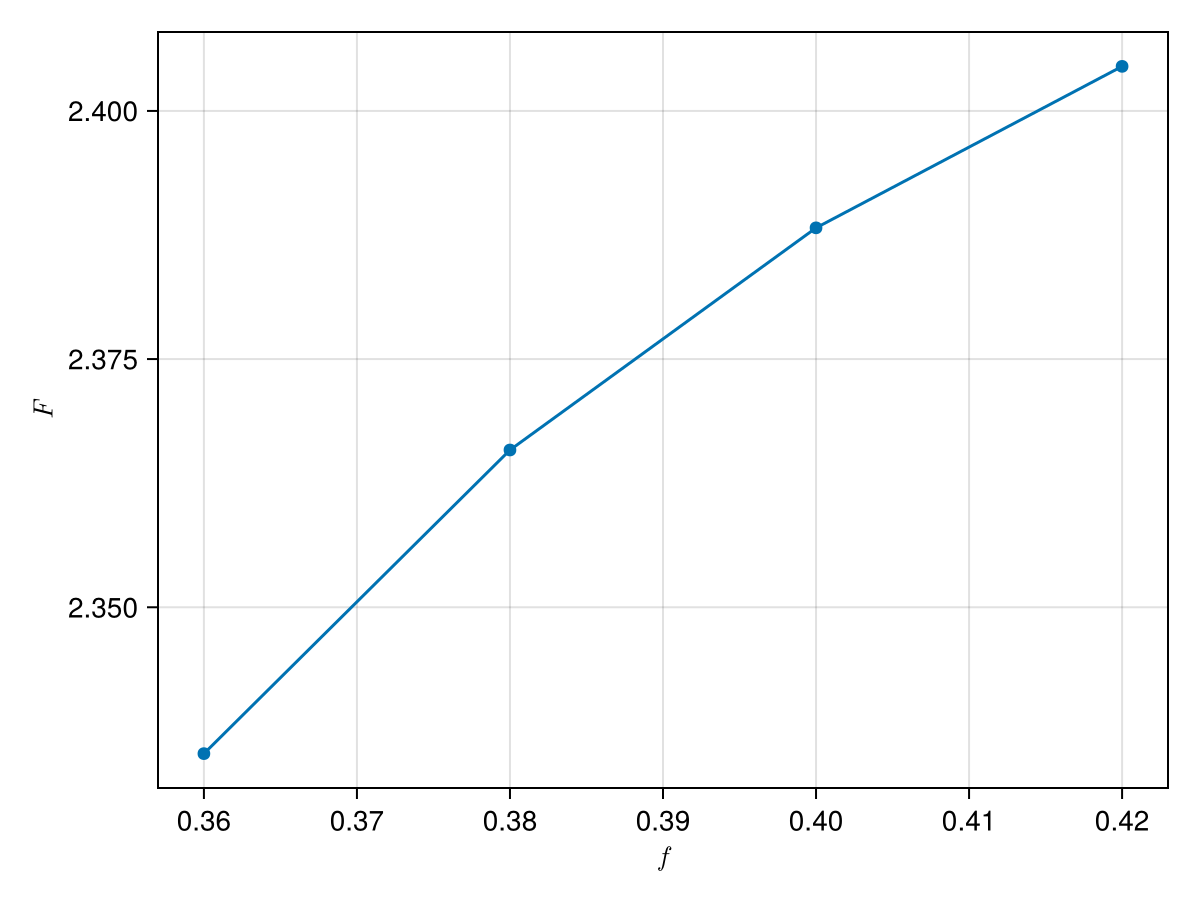

In [9]:
let
	f = Figure()
	ax = Axis(f[1, 1],
	    xlabel = L"f",
	    ylabel = L"F",
	)
	lines!(ax, fAs_lam, Fs_lam, label=nothing)
	scatter!(ax, fAs_lam, Fs_lam, label="F")
	f
end

#### Exercises

1. Compute the free energies of the LAM phase for the same system with `χN=20.0` and `fA=[0.36, 0.38, 0.40, 0.42]`.

### Batch evaluations of HEX

We can compute the free energies of HEX for a list of $f_A$ values.

In [10]:
scft_AB_hex = let
	ds = 0.01
	uc = UnitCell(Hexagonal2D(), 3.6)  # A simple cell with side length 3.6 Rg
	lat = BravaisLattice(uc, 17)  # space group No.17
	system = AB_system(χN=15.0, fA=0.36)
	NoncyclicChainSCFT(system, lat, ds)
end;

In [11]:
let
	scftconfig = SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
    config = Polyorder.Config(scft=scftconfig)
	JP.solve!(scft_AB_hex, config)
end

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3966759663                                                                 
resediual norm: 0.914                                                           
number: 200                                                                     
F: 2.3282342427                                                                 
resediual norm: 0.181                                                           
number: 300                                                                     
F: 2.3276892762     

[ Info: final loss: 0.0009969193569188128
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3276902138
[ Info: final loss: 0.000997
[ Info: final stress norm: 0.029823494689267108
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: iterations: 362
[ Info: time per iteration: 22 milliseconds, 153 microseconds, 354 nanoseconds
[ Info: Run time: 00:00:08.01951425
[ Info: =======================================


Polyorder.Successful()

In [12]:
begin
	# volume fractions for AB component
	fAs_hex = [0.36, 0.38, 0.4, 0.42]
	Fs_hex = similar(fAs_hex)
	μs_hex = similar(fAs_hex)
	info_hex = []
end

Any[]

In [13]:
let
	scft = JP.clone(scft_AB_hex)
	scftconfig = SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
    config = Polyorder.Config(scft=scftconfig)
	for i in eachindex(fAs_hex)
		system = Polymer.update!(scft.system, fAs_hex[i], fA_ctrl)
		lat = JP.lattice(scft)
		scft = Polyorder.reset(scft, lat, system)
		updater = VariableCell(BB(1.0), SD(0.2))
		conv, _ = cell_solve!(scft, updater, config)
		Fs_hex[i], μs_hex[i] = JP.F(scft), JP.μ̃(scft, 1)
		# Store extra information
		info = (convgence=conv, fA=fAs_hex[i], 
				F = JP.F(scft),
				Lx=first(JP.unitcell(scft).edges),
				Nx=first(size(first(scft.ϕfields))))
		push!(info_hex, info)
	end
end

[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (stress norm)
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 709.4628128789
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [3.6, 3.6]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                

[ Info: final loss: 0.00013699294453184407
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3150938382
[ Info: final loss: 0.000137
[ Info: final stress norm: 2.08e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.030712129794332, 4.030712129794332]
└   * Angles: [2π/3, 0]
[ Info: iterations: 141
[ Info: time per iteration: 43 milliseconds, 24 microseconds, 880 nanoseconds
[ Info: Run time: 00:00:06.066508083
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.030712129794332, 4.030712129794332]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.3150938382484596
[ Info: Final loss: 0.00013

[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
┌ Info: Algorithm: Variable cell method
│ * cell updater: Barzilai-Borwein (BB2) method with max step size =1.0.
│ * fields updater: PicardMann iteration with α=0.2.
└ Run fields updater 1 times per cell iteration.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (stress norm)
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 0.5762459515
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.030712129794332, 4.030712129794332]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                      

[ Info: final loss: 0.0006074220367930927
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3579577477
[ Info: final loss: 0.000607
[ Info: final stress norm: 7.74e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.104254314055721, 4.104254314055721]
└   * Angles: [2π/3, 0]
[ Info: iterations: 108
[ Info: time per iteration: 37 milliseconds, 497 microseconds, 91 nanoseconds
[ Info: Run time: 00:00:04.049685833
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.104254314055721, 4.104254314055721]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.3579577477456897
[ Info: Final loss: 0.000607

[ Info: final loss: 0.00020131572410164722
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3939250887
[ Info: final loss: 0.000201
[ Info: final stress norm: 6.9e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.172655947970644, 4.172655947970644]
└   * Angles: [2π/3, 0]
[ Info: iterations: 146
[ Info: time per iteration: 36 milliseconds, 276 microseconds, 528 nanoseconds
[ Info: Run time: 00:00:05.296373166
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.172655947970644, 4.172655947970644]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.393925088686119
[ Info: Final loss: 0.000201

[ Info: final loss: 0.00046845474644463536
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4240959241
[ Info: final loss: 0.000468
[ Info: final stress norm: 8.01e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.235041438356796, 4.235041438356796]
└   * Angles: [2π/3, 0]
[ Info: iterations: 115
[ Info: time per iteration: 38 milliseconds, 339 microseconds, 290 nanoseconds
[ Info: Run time: 00:00:04.409018375
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.235041438356796, 4.235041438356796]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.4240959241141704
[ Info: Final loss: 0.0004

Free energy as a function of $f_A$ for HEX:

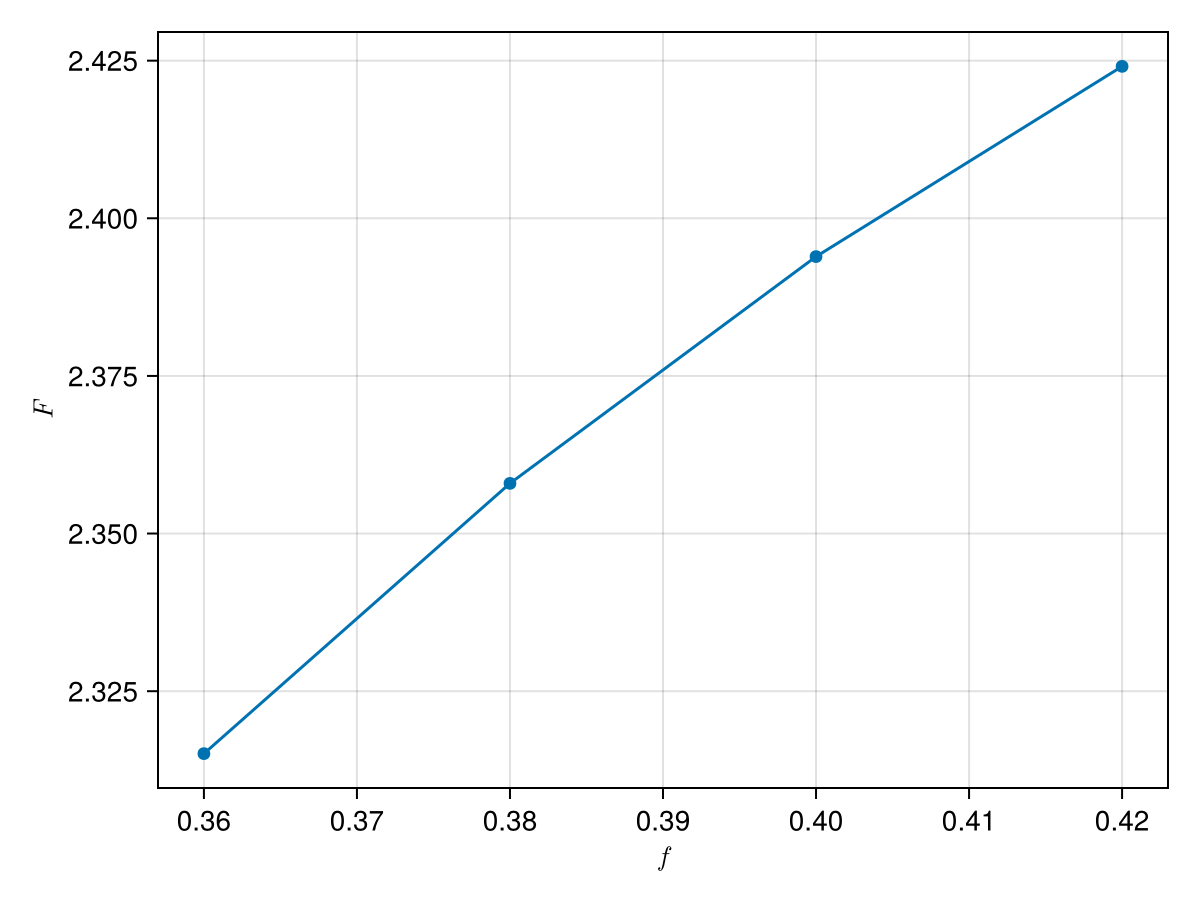

In [14]:
let
	f = Figure()
	ax = Axis(f[1, 1],
	    xlabel = L"f",
	    ylabel = L"F",
	)
	lines!(ax, fAs_hex, Fs_hex, label=nothing)
	scatter!(ax, fAs_hex, Fs_hex, label="HEX")
	f
end

#### Exercises

1. Compute the free energies of the HEX phase for the same system with χN=20.0 and fA=[0.36, 0.38, 0.40, 0.42].

### Determine the phase boundary

Let us first visualize the curves by plotting them together:

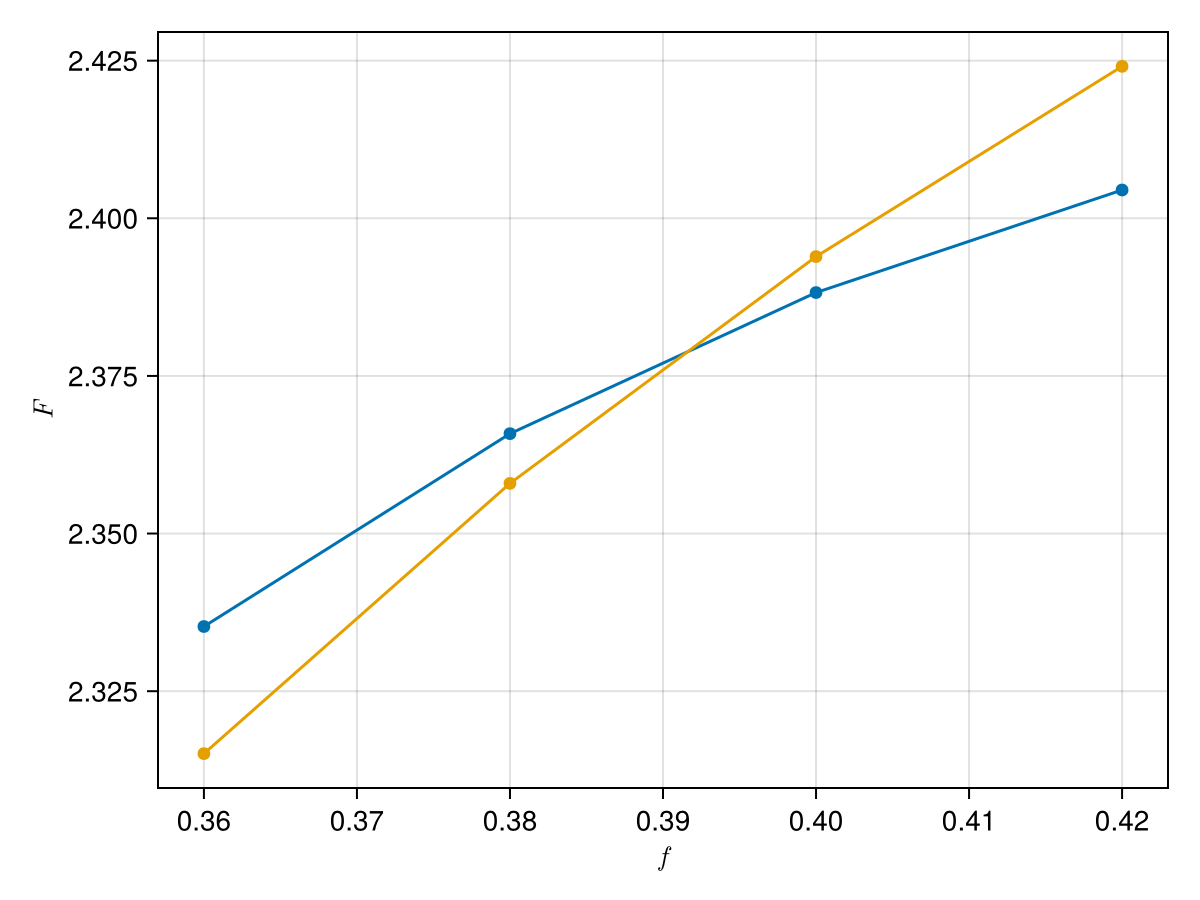

In [15]:
let
	f = Figure()
	ax = Axis(f[1, 1],
	    xlabel = L"f",
	    ylabel = L"F",
	)
	lines!(ax, fAs_lam, Fs_lam, label=nothing)
	scatter!(ax, fAs_lam, Fs_lam, label="LAM")
	lines!(ax, fAs_hex, Fs_hex, label=nothing)
	scatter!(ax, fAs_hex, Fs_hex, label="HEX")
	f
end

It can be easily seen that the phase boundary locates among the interval [0.38, 0.4]. A convenient approximation of the phase boundary point is connecting the free energy point by straight line segment for each phase and finding the intersection point.

In [16]:
fb_manual = let
	fa_lam, Fa_lam, fb_lam, Fb_lam  = 0.38, Fs_lam[2], 0.4, Fs_lam[3]
	fa_hex, Fa_hex, fb_hex, Fb_hex  = 0.38, Fs_hex[2], 0.4, Fs_hex[3]
	# Line segment for LAM phase: y = k_lam (x - fa_lam) + Fa_lam
	k_lam = (Fb_lam - Fa_lam) / (fb_lam - fa_lam)
	# Line segment for HEX phase: y = k_hex (x - fa_hex) + Fa_hex 
	k_hex = (Fb_hex - Fa_hex) / (fb_hex - fa_hex)
	# The intersection of two lines are found by solving: (k_lam-k_hex)x + (k_hex*fa_hex-k_lam*fa_lam) + (Fa_lam - Fa_hex) = 0
	f_boundary = ((k_hex*fa_hex-k_lam*fa_lam) + (Fa_lam - Fa_hex)) / (k_hex - k_lam)
end

0.3916055181758115

The approximate boundary locates around $f_A=0.3916$. To increase the accuracy of the approximation, you can refine the grid, i.e. adding more points among the interval [0.38, 0.4].

## Semi-automated construction

The above manual construction of phase diagrams can be automated. The determination of the phase boundary point is essentially a root-finding problem. Thus root-finding algorithms can be utilized to solve the problem. PhaseDiagram.jl has implemented such approach.

We first create a `PolyorderModel` instance which wraps the SCFT model and its full configuration:

In [17]:
function model_lam()
	# create a SCFT model
	ds = 0.01
	uc = UnitCell(3.0)
	lat = BravaisLattice(uc)
	system = AB_system(χN=15.0, fA=0.36)
	scft = NoncyclicChainSCFT(system, lat, ds)
	# prepare a full configuration
	io = JP.IOConfig(base_dir="microphase")
	scftconfig = JP.SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
	config = JP.Config(; io, scft=scftconfig)
	# prepare a well converged SCFT model via a stable SD updater
	JP.solve!(scft, config)
	# prepare a SCFT model with an accelerated updater and good intial guess from previous converged model
	scft_new = NoncyclicChainSCFT(system, lat, ds; updater=SIS(1.0))
	# Copy the well converged phase structure to the new SCFT model.
	JP.initialize!(scft_new, scft.wfields)

	return PolyorderModel(scft_new, config, false)
end

model_lam (generic function with 1 method)

It is a good habit to check whether the initial model has the correct phase structure by plotting its density field. It is critical to make sure that the expected phase structrure is generated by the intial model before going to the next step.

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3895099208                                                                 
resediual norm: 0.603                                                           
number: 200                                                                     
F: 2.361885225                                                                  
resediual norm: 0.00323                                                         
[ Info: final loss: 0.00043744708061943527
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > 

[ Info: final loss: 0.00038981175897268017
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619036953
[ Info: final loss: 0.00039
[ Info: final stress norm: 0.09399374794149974
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: iterations: 4
[ Info: time per iteration: 149 milliseconds, 431 microseconds, 93 nanoseconds
[ Info: Run time: 00:00:00.597724375
[ Info: =======================================


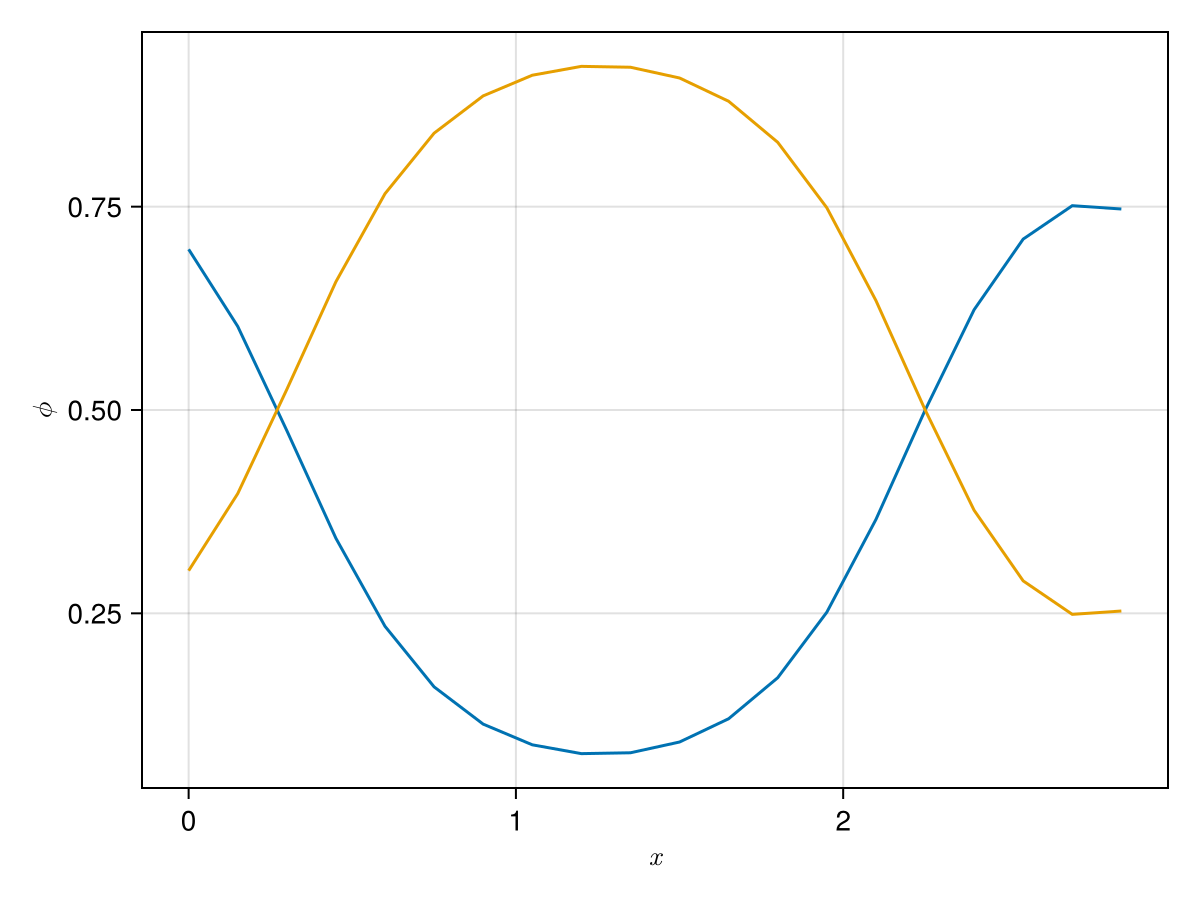

In [18]:
let
	m = model_lam()
	JP.solve!(m.scft, m.config)  # one-step solving converts auxiliary fields to density fields.
	plot_density(m.scft)
end

In [19]:
function model_hex()
	ds = 0.01
	uc = UnitCell(Hexagonal2D(), 4.2)  # A simple cell with side length 4.2 Rg
	lat = BravaisLattice(uc, 17)  # space group No.17
	system = AB_system(χN=15.0, fA=0.36)
	scft = NoncyclicChainSCFT(system, lat, ds)
	# prepare a full configuration
	io = JP.IOConfig(base_dir="microphase")
	scftconfig = JP.SCFTConfig(symmetrize=false, max_iter=500, tolmode=:F, tol=1e-8)
	config = JP.Config(; io, scft=scftconfig)
	# prepare a well converged SCFT model via a stable SD updater
	JP.solve!(scft, config)
	# prepare a SCFT model with an accelerated updater and good intial guess from previous converged model
	scft_new = NoncyclicChainSCFT(system, lat, ds; updater=SIS(1.0))
	JP.initialize!(scft_new, scft.wfields)

	return PolyorderModel(scft_new, config, false)
end

model_hex (generic function with 1 method)

Check whether the hexagonal cyclinder phase is generated by the `model_hex` function.

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 5.2689882386
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.4333366036                                                                 
resediual norm: 0.672                                                           
number: 200                                                                     
F: 2.317077994                                                                  
resediual norm: 0.083                                                           
number: 300                                                                     
F: 2.316964

[ Info: final loss: 0.000981641837470404
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3169608418
[ Info: final loss: 0.000982
[ Info: final stress norm: 0.010818448982257145
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: iterations: 421
[ Info: time per iteration: 16 milliseconds, 429 microseconds, 583 nanoseconds
[ Info: Run time: 00:00:06.916854625
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 724.5379430495
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges:

[ Info: final loss: 0.0009321977342633403
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3169608405
[ Info: final loss: 0.000932
[ Info: final stress norm: 0.010818449835723871
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: iterations: 2
[ Info: time per iteration: 666 milliseconds, 649 microseconds, 583 nanoseconds
[ Info: Run time: 00:00:01.333299167
[ Info: =======================================


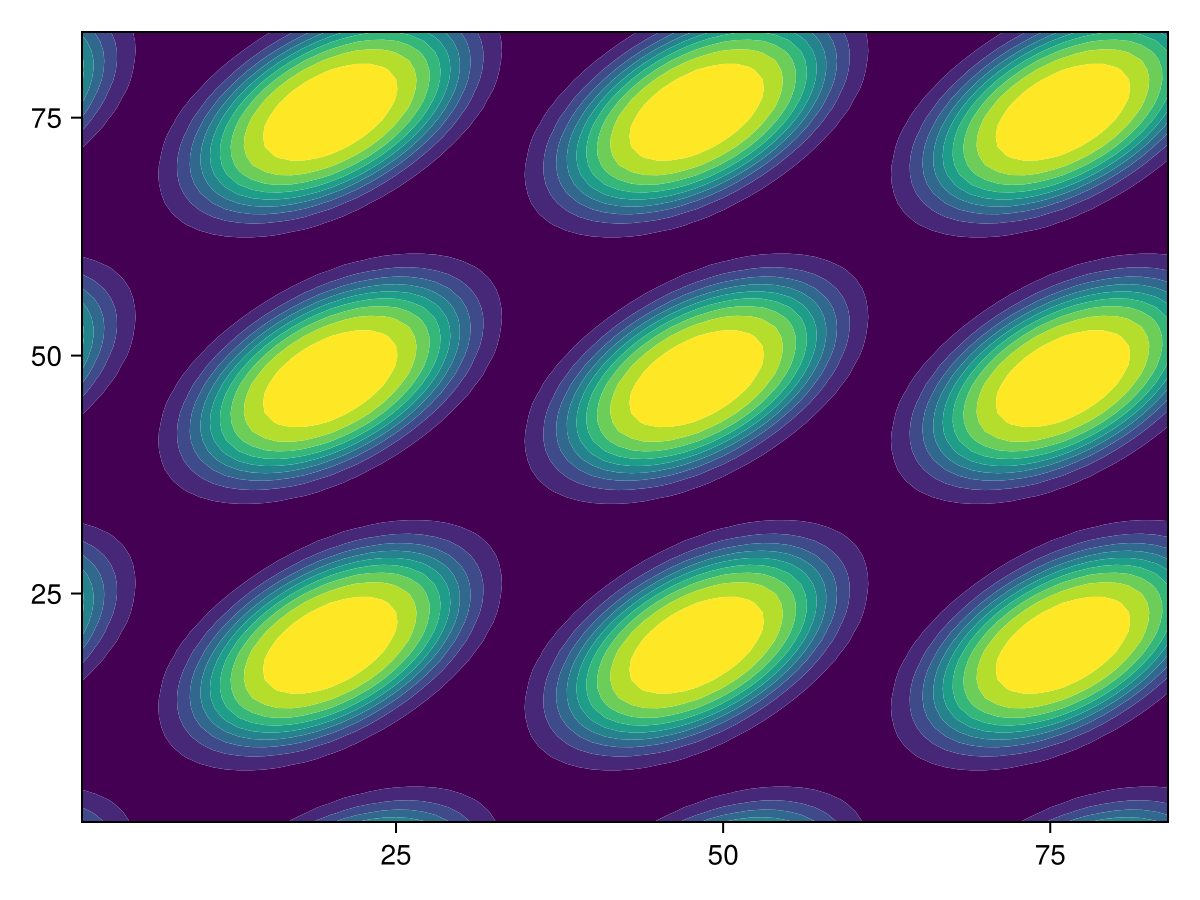

In [20]:
let
	m = model_hex()
	JP.solve!(m.scft, m.config)  # one-step solving converts auxiliary fields to density fields.
	plot_density(m.scft)
end

We use the `microphase` function to find the phase boundary point automatically using a root-finding algorithm enclosed in the `RootsOptimizer` instance. A `MicrophaseModel` object is required by the `microphase` function.

In [21]:
fb_auto = let
	mipm = MicrophaseModel(model_lam(), model_hex(), fA_ctrl,
						   a=0.36, b=0.42, phase1=LAMPhase, phase2=HEXPhase,
						   cache=true)
	f, tracker = microphase(RootsOptimizer(), mipm)
end

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 2.3627281701                                                                 
resediual norm: 0.49                                                            
number: 200                                                                     
F: 2.3619029521                                                                 
resediual norm: 0.00183                                                         
[ Info: final loss: 0.0003887181181321253
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > S

number: 500                                                                     
F: 2.3359587417                                                                 
resediual norm: 0.0573                                                          
[ Info: final loss: 0.057345486869426754
[ Info: Stop triggered by EarlyStopping.NumberLimit(500) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.NeedMoreIteration()
[ Info: final F: 2.3359587417
[ Info: final loss: 0.0573
[ Info: final stress norm: 0.005085859820957913
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: iterations: 500
[ Info: time per iteration: 16 milliseconds, 533 microseconds, 215 nanoseconds
[ Info: Run time: 00:00:08.266607917
[ Info: =======================================


[ Info: ======================================================
[ Info: 
[ Info: 	 f = 0.36 	 phase: LAM
[ Info: 
[ Info: ======================================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 0.00034820581469841017
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619036964
[ Info: final loss: 0.000348
[ Info: final stress norm: 0.09399373506192969
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges:

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3619036964
[ Info: initial residual norm: 0.000348
[ Info: initial stress norm: 0.094
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 0.0003239607678633405
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3619036989
[ Info: final loss: 0.000324
[ Info: final stress norm: 0.09399354915229624
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.0]
└   * Angles: [0]
[ Info: iterations: 2
[ Info: time per iteration: 185 microseconds, 771 nanoseconds
[ Info: Run time: 00:00:00.000371542
[ Info: =======

number: 100                                                                     
F: 2.336026301                                                                  
resediual norm: 7.83e-5                                                         
[ Info: final loss: 7.436920494274801e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3360263103
[ Info: final loss: 7.44e-5
[ Info: final stress norm: 0.016120107594117063
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.469967745761481]
└   * Angles: [0]
[ Info: iterations: 101
[ Info: time per iteration: 4 milliseconds, 112 microseconds, 643 nanoseconds
[ Info: Run time: 00:00:00.415377042
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info

[ Info: final loss: 0.0009991828147914994
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3993180544
[ Info: final loss: 0.000999
[ Info: final stress norm: 0.06627358150948108
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [5.349838728807406]
└   * Angles: [0]
[ Info: iterations: 281
[ Info: time per iteration: 17 milliseconds, 244 microseconds, 713 nanoseconds
[ Info: Run time: 00:00:04.845764375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [4.174919364403703]
└

[ Info: final loss: 4.048712681070654e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3621034926
[ Info: final loss: 4.05e-5
[ Info: final stress norm: 0.08276821987591586
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [4.174919364403703]
└   * Angles: [0]
[ Info: iterations: 319
[ Info: time per iteration: 17 milliseconds, 540 microseconds, 957 nanoseconds
[ Info: Run time: 00:00:05.595565375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -1.7870545344
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 7.45
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.624766552

number: 100                                                                     
F: 2.3355155182                                                                 
resediual norm: 8.27e-5                                                         
[ Info: final loss: 7.591703807463546e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.335515497
[ Info: final loss: 7.59e-5
[ Info: final stress norm: 0.008879005736791375
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6247665523784054]
└   * Angles: [0]
[ Info: iterations: 102
[ Info: time per iteration: 3 milliseconds, 577 microseconds, 775 nanoseconds
[ Info: Run time: 00:00:00.364933084
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info

[ Info: final loss: 3.0503238914292297e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352562407
[ Info: final loss: 3.05e-5
[ Info: final stress norm: 0.00031185499859463637
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.570842492567661]
└   * Angles: [0]
[ Info: iterations: 78
[ Info: time per iteration: 3 milliseconds, 931 microseconds, 598 nanoseconds
[ Info: Run time: 00:00:00.306664667
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3352562407
[ Info: initial residual norm: 3.05e-5
[ Info: initial stress norm: 0.000376
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.

[ Info: final loss: 0.00010394329567375848
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3389433029
[ Info: final loss: 0.000104
[ Info: final stress norm: 0.03529176166506242
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.3551462533246843]
└   * Angles: [0]
[ Info: iterations: 84
[ Info: time per iteration: 3 milliseconds, 531 microseconds, 885 nanoseconds
[ Info: Run time: 00:00:00.296678375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3389433029
[ Info: initial residual norm: 0.000104
[ Info: initial stress norm: 0.0293
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5

[ Info: final loss: 4.524268361194572e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352553215
[ Info: final loss: 4.52e-5
[ Info: final stress norm: 8.233954376321712e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5689531915165507]
└   * Angles: [0]
[ Info: iterations: 96
[ Info: time per iteration: 3 milliseconds, 692 microseconds, 304 nanoseconds
[ Info: Run time: 00:00:00.354461208
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5689531915165507]
└   * Angles: [0]
[ Info: Final F: 2.3352553215387046
[ Info: Final loss: 4.524268361194572e-5
[ Info: Final stress: 8.233954376321712e-6
[ Info: Tot

[ Info: final loss: 0.0009954010765859111
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3356414267
[ Info: final loss: 0.000995
[ Info: final stress norm: 0.004696685748254805
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: iterations: 394
[ Info: time per iteration: 17 milliseconds, 118 microseconds, 416 nanoseconds
[ Info: Run time: 00:00:06.74465625
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...


[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3356414267
[ Info: initial residual norm: 0.000995
[ Info: initial stress norm: 0.0047
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 0.0009747416167462664
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3356414224
[ Info: final loss: 0.000975
[ Info: final stress norm: 0.004696680464637338
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2, 4.2]
└   * Angles: [2π/3, 0]
[ Info: iterations: 2
[ Info: time per iteration: 18 milliseconds, 137 microseconds, 458 nanosecon

[ Info: final loss: 0.0006924510573627085
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3356004105
[ Info: final loss: 0.000692
[ Info: final stress norm: 0.004420292371402488
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.195303319535363, 4.195303319535363]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 16 milliseconds, 443 microseconds, 779 nanoseconds
[ Info: Run time: 00:00:00.575532292
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3356004105
[ Info: initial residual norm: 0.000692
[ Info: initial stress norm: 0.00448
┌ Info: initial unit cell: UnitCell
│   * Cryst

[ Info: final loss: 0.00039141202040382517
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.335449826
[ Info: final loss: 0.000391
[ Info: final stress norm: 0.003312813425343981
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.176516597676813, 4.176516597676813]
└   * Angles: [2π/3, 0]
[ Info: iterations: 55
[ Info: time per iteration: 17 milliseconds, 31 microseconds, 194 nanoseconds
[ Info: Run time: 00:00:00.936715708
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.335449826
[ Info: initial residual norm: 0.000391
[ Info: initial stress norm: 0.00355
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 0.0001816555412452736
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3353376288
[ Info: final loss: 0.000182
[ Info: final stress norm: 0.002325316685336825
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.0825829883840665, 4.0825829883840665]
└   * Angles: [2π/3, 0]
[ Info: iterations: 79
[ Info: time per iteration: 17 milliseconds, 11 microseconds, 996 nanoseconds
[ Info: Run time: 00:00:01.34394775
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3353376288
[ Info: initial residual norm: 0.000182
[ Info: initial stress norm: 0.00226
┌ Info: initial unit cell: UnitCell
│   * Cryst

[ Info: final loss: 9.130917636235303e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352554245
[ Info: final loss: 9.13e-5
[ Info: final stress norm: 1.8771819629281262e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121323738369341, 4.121323738369341]
└   * Angles: [2π/3, 0]
[ Info: iterations: 76
[ Info: time per iteration: 16 milliseconds, 19 microseconds, 869 nanoseconds
[ Info: Run time: 00:00:01.217510083
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3352554245
[ Info: initial residual norm: 9.13e-5
[ Info: initial stress norm: 1.88e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 6.341552820376961e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352554805
[ Info: final loss: 6.34e-5
[ Info: final stress norm: 2.547710819368345e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121008021089566, 4.121008021089566]
└   * Angles: [2π/3, 0]
[ Info: iterations: 27
[ Info: time per iteration: 16 milliseconds, 396 microseconds, 245 nanoseconds
[ Info: Run time: 00:00:00.442698625
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3352554805
[ Info: initial residual norm: 6.34e-5
[ Info: initial stress norm: 2.55e-7
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3352557231
[ Info: final loss: 6.27e-5
[ Info: final stress norm: 1.3146058822938518e-9
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121012248627446, 4.121012248627446]
└   * Angles: [2π/3, 0]
[ Info: iterations: 2
[ Info: time per iteration: 18 milliseconds, 94 microseconds, 667 nanoseconds
[ Info: Run time: 00:00:00.036189334
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121012248627446, 4.121012248627446]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.335255723061188
[ Info: Final loss: 6.26940174386359e-5
[ Info: Final stress: 1.3146058822938518e-9
[ Info: Total solve! calls: 7
[ Info: Total SCFT iterations: 276
[ Info: Total time: 00:00:05
[ I

number: 100                                                                     
F: 2.4056320973                                                                 
resediual norm: 0.000254                                                        
[ Info: final loss: 0.0002034415855272087
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4056322259
[ Info: final loss: 0.000203
[ Info: final stress norm: 0.02201399309785564
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5689531915165507]
└   * Angles: [0]
[ Info: iterations: 105
[ Info: time per iteration: 3 milliseconds, 684 microseconds, 811 nanoseconds
[ Info: Run time: 00:00:00.38690525
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cel

[ Info: final loss: 6.624798750065608e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.405204182
[ Info: final loss: 6.62e-5
[ Info: final stress norm: 0.017394357129808965
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5909671092771127]
└   * Angles: [0]
[ Info: iterations: 52
[ Info: time per iteration: 3 milliseconds, 510 microseconds, 532 nanoseconds
[ Info: Run time: 00:00:00.182547667
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.405204182
[ Info: initial residual norm: 6.62e-5
[ Info: initial stress norm: 0.0162
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.679022

[ Info: final loss: 4.1270042057117706e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044899183
[ Info: final loss: 4.13e-5
[ Info: final stress norm: 0.0006918888732931679
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6790227803193605]
└   * Angles: [0]
[ Info: iterations: 78
[ Info: time per iteration: 3 milliseconds, 580 microseconds, 414 nanoseconds
[ Info: Run time: 00:00:00.279272333
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.4044899183
[ Info: initial residual norm: 4.13e-5
[ Info: initial stress norm: 0.000694
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.

[ Info: final loss: 5.1059245587126156e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.404489817
[ Info: final loss: 5.11e-5
[ Info: final stress norm: 1.1708394204650885e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.675654212900005]
└   * Angles: [0]
[ Info: iterations: 37
[ Info: time per iteration: 3 milliseconds, 371 microseconds, 635 nanoseconds
[ Info: Run time: 00:00:00.1247505
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.404489817
[ Info: initial residual norm: 5.11e-5
[ Info: initial stress norm: 1.17e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.675597

[ Info: initial F: 2.4044886306
[ Info: initial residual norm: 1.4e-5
[ Info: initial stress norm: 3.21e-7
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.675370611968159]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 8.059560274631394e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044905271
[ Info: final loss: 8.06e-5
[ Info: final stress norm: 4.688661325678121e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.675370611968159]
└   * Angles: [0]
[ Info: iterations: 13
[ Info: time per iteration: 4 milliseconds, 365 microseconds, 820 nanoseconds
[ Info: Run time: 00:00:00.056755667
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (S

[ Info: final loss: 1.268657728736855e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044883603
[ Info: final loss: 1.27e-5
[ Info: final stress norm: 3.4595996742035704e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755959506922777]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 837 microseconds, 958 nanoseconds
[ Info: Run time: 00:00:00.099786917
[ Info: =======================================


[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755959506922777]
└   * Angles: [0]
[ Info: Final F: 2.4044883603094624
[ Info: Final loss: 1.268657728736855e-5
[ Info: Final stress: 3.4595996742035704e-7
[ Info: Total solve! calls: 7
[ Info: Total SCFT iterations: 220
[ Info: Total time: 00:00:01
[ Info: ======================================================
[ Info: 
[ Info: 	 f = 0.42 	 phase: HEX
[ Info: 
[ Info: ======================================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 6.2030499757
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121012248627446, 4.121012248

[ Info: final loss: 0.00020402515927209208
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4056333572
[ Info: final loss: 0.000204
[ Info: final stress norm: 0.00953707344498823
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.121012248627446, 4.121012248627446]
└   * Angles: [2π/3, 0]
[ Info: iterations: 105
[ Info: time per iteration: 16 milliseconds, 810 microseconds, 884 nanoseconds
[ Info: Run time: 00:00:01.765142875
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial

[ Info: final loss: 4.224908096928104e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4054609425
[ Info: final loss: 4.22e-5
[ Info: final stress norm: 0.008784441425815843
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.130549289439338, 4.130549289439338]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 16 milliseconds, 821 microseconds, 62 nanoseconds
[ Info: Run time: 00:00:00.87469525
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.4054609425
[ Info: initial residual norm: 4.22e-5
[ Info: initial stress norm: 0.00855
┌ Info: initial unit cell: UnitCell
│   * Crystal sy

[ Info: final loss: 3.952297399867355e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4049109807
[ Info: final loss: 3.95e-5
[ Info: final stress norm: 0.0057979358244709235
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.168697452686903, 4.168697452686903]
└   * Angles: [2π/3, 0]
[ Info: iterations: 63
[ Info: time per iteration: 16 milliseconds, 350 microseconds, 609 nanoseconds
[ Info: Run time: 00:00:01.030088375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -1.4986168516
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system

[ Info: final loss: 5.0053434901276006e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4054952703
[ Info: final loss: 5.01e-5
[ Info: final stress norm: 0.00854864541518617
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.359438268924731, 4.359438268924731]
└   * Angles: [2π/3, 0]
[ Info: iterations: 88
[ Info: time per iteration: 17 milliseconds, 159 microseconds, 97 nanoseconds
[ Info: Run time: 00:00:01.510000542
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -0.9840635073
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: 

[ Info: final loss: 4.5046967103168356e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044885246
[ Info: final loss: 4.5e-5
[ Info: final stress norm: 0.00011919619535824648
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2457822294138605, 4.2457822294138605]
└   * Angles: [2π/3, 0]
[ Info: iterations: 78
[ Info: time per iteration: 16 milliseconds, 851 microseconds, 736 nanoseconds
[ Info: Run time: 00:00:01.314435459
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.4044885246
[ Info: initial residual norm: 4.5e-5
[ Info: initial stress norm: 0.000119
┌ Info: initial unit cell: UnitCell
│   * Crys

[ Info: final loss: 2.6070890406515446e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044888406
[ Info: final loss: 2.61e-5
[ Info: final stress norm: 2.3307654508582845e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244242073865328, 4.244242073865328]
└   * Angles: [2π/3, 0]
[ Info: iterations: 37
[ Info: time per iteration: 16 milliseconds, 966 microseconds, 38 nanoseconds
[ Info: Run time: 00:00:00.627743417
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.4044888406
[ Info: initial residual norm: 2.61e-5
[ Info: initial stress norm: 2.34e-6
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044927393
[ Info: final loss: 7.93e-5
[ Info: final stress norm: 0.00046514379007179775
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.2380814516711975, 4.2380814516711975]
└   * Angles: [2π/3, 0]
[ Info: iterations: 37
[ Info: time per iteration: 16 milliseconds, 637 microseconds, 536 nanoseconds
[ Info: Run time: 00:00:00.615588833
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.4044927393
[ Info: initial residual norm: 7.93e-5
[ Info: initial stress norm: 0.000463
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244211357829137, 4.244211357829137]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >

[ Info: final loss: 8.061886643595528e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.4044854713
[ Info: final loss: 8.06e-5
[ Info: final stress norm: 3.435361540777189e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244211357829137, 4.244211357829137]
└   * Angles: [2π/3, 0]
[ Info: iterations: 37
[ Info: time per iteration: 16 milliseconds, 458 microseconds, 551 nanoseconds
[ Info: Run time: 00:00:00.608966417
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244211357829137, 4.244211357829137]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.4044854713370483
[ Info: Final loss: 8.0618866435

[ Info: final loss: 0.0002551777103252384
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3493481372
[ Info: final loss: 0.000255
[ Info: final stress norm: 0.01417488971064988
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755959506922777]
└   * Angles: [0]
[ Info: iterations: 94
[ Info: time per iteration: 3 milliseconds, 699 microseconds, 95 nanoseconds
[ Info: Run time: 00:00:00.347714958
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3493481372
[ Info: initial re

[ Info: final loss: 0.0001279412392332091
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3493484316
[ Info: final loss: 0.000128
[ Info: final stress norm: 0.014174983180837337
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6755959506922777]
└   * Angles: [0]
[ Info: iterations: 16
[ Info: time per iteration: 4 milliseconds, 586 microseconds, 869 nanoseconds
[ Info: Run time: 00:00:00.073389917
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3493484316
[ Info: initial residual norm: 0.000128
[ Info: initial stress norm: 0.0143
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6

[ Info: final loss: 2.3319965301027423e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3491618194
[ Info: final loss: 2.33e-5
[ Info: final stress norm: 0.011857221620720572
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6614209675114404]
└   * Angles: [0]
[ Info: iterations: 59
[ Info: time per iteration: 4 milliseconds, 41 microseconds, 518 nanoseconds
[ Info: Run time: 00:00:00.238449583
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3491618194
[ Info: initial residual norm: 2.33e-5
[ Info: initial stress norm: 0.0124
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6047

[ Info: final loss: 7.901242943031406e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487449605
[ Info: final loss: 7.9e-5
[ Info: final stress norm: 0.0024539496229926227
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.604721034788091]
└   * Angles: [0]
[ Info: iterations: 60
[ Info: time per iteration: 4 milliseconds, 68 microseconds, 172 nanoseconds
[ Info: Run time: 00:00:00.244090334
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3487449605
[ Info: initial residual norm: 7.9e-5
[ Info: initial stress norm: 0.00314
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.321221

[ Info: final loss: 0.00015666998022556555
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3549069935
[ Info: final loss: 0.000157
[ Info: final stress norm: 0.04702088656216676
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.3212213711713443]
└   * Angles: [0]
[ Info: iterations: 82
[ Info: time per iteration: 4 milliseconds, 280 microseconds, 783 nanoseconds
[ Info: Run time: 00:00:00.35102425
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3549069935
[ Info: initial residual norm: 0.000157
[ Info: initial stress norm: 0.0372
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59

[ Info: final loss: 4.7763407633905075e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487229182
[ Info: final loss: 4.78e-5
[ Info: final stress norm: 9.004820021262896e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590659464375867]
└   * Angles: [0]
[ Info: iterations: 99
[ Info: time per iteration: 3 milliseconds, 940 microseconds, 418 nanoseconds
[ Info: Run time: 00:00:00.390101459
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3487229182
[ Info: initial residual norm: 4.78e-5
[ Info: initial stress norm: 9.01e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590

[ Info: final loss: 1.2863609220481464e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487232614
[ Info: final loss: 1.29e-5
[ Info: final stress norm: 1.3153273326274053e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590116446056244]
└   * Angles: [0]
[ Info: iterations: 35
[ Info: time per iteration: 3 milliseconds, 967 microseconds, 342 nanoseconds
[ Info: Run time: 00:00:00.138857
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3487232614
[ Info: initial residual norm: 1.29e-5
[ Info: initial stress norm: 1.32e-6
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59012

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.348722852
[ Info: final loss: 6.0e-6
[ Info: final stress norm: 2.0642317358466908e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590124263692637]
└   * Angles: [0]
[ Info: iterations: 13
[ Info: time per iteration: 3 milliseconds, 620 microseconds, 391 nanoseconds
[ Info: Run time: 00:00:00.047065084
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590124263692637]
└   * Angles: [0]
[ Info: Final F: 2.348722851998652
[ Info: Final loss: 5.998508604498909e-6
[ Info: Final stress: 2.0642317358466908e-7
[ Info: Total solve! calls: 7
[ Info: Total SCFT iterations: 364
[ Info: Total time: 00:00:02
[ Info: ======================================================
[ In

[ Info: final loss: 0.0002494952947378337
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3493481213
[ Info: final loss: 0.000249
[ Info: final stress norm: 0.0061378297697404485
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244211357829137, 4.244211357829137]
└   * Angles: [2π/3, 0]
[ Info: iterations: 94
[ Info: time per iteration: 18 milliseconds, 948 microseconds, 731 nanoseconds
[ Info: Run time: 00:00:01.78118075
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial 

[ Info: final loss: 0.00012625865952120563
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3493484157
[ Info: final loss: 0.000126
[ Info: final stress norm: 0.006137870338710871
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.244211357829137, 4.244211357829137]
└   * Angles: [2π/3, 0]
[ Info: iterations: 16
[ Info: time per iteration: 17 milliseconds, 832 microseconds, 622 nanoseconds
[ Info: Run time: 00:00:00.285321958
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3493484157
[ Info: initial residual norm: 0.000126
[ Info: initial stress norm: 0.00616
┌ Info: initial unit cell: UnitCell
│   * Crys

[ Info: final loss: 2.0034256188239397e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.349274649
[ Info: final loss: 2.0e-5
[ Info: final stress norm: 0.005762259628512
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.238073487490426, 4.238073487490426]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 18 milliseconds, 732 microseconds, 805 nanoseconds
[ Info: Run time: 00:00:00.974105875
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.349274649
[ Info: initial residual norm: 2.0e-5
[ Info: initial stress norm: 0.00586
┌ Info: initial unit cell: UnitCell
│   * Crystal system

[ Info: final loss: 2.8886501659108887e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3490252325
[ Info: final loss: 2.89e-5
[ Info: final stress norm: 0.004251250323242205
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.213522006135583, 4.213522006135583]
└   * Angles: [2π/3, 0]
[ Info: iterations: 60
[ Info: time per iteration: 16 milliseconds, 712 microseconds, 56 nanoseconds
[ Info: Run time: 00:00:01.002723375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: NaN
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal

[ Info: final loss: 5.1387682719283845e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489031224
[ Info: final loss: 5.14e-5
[ Info: final stress norm: 0.0034877078778758224
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.090764599361365, 4.090764599361365]
└   * Angles: [2π/3, 0]
[ Info: iterations: 78
[ Info: time per iteration: 18 milliseconds, 661 microseconds, 352 nanoseconds
[ Info: Run time: 00:00:01.455585458
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489031224
[ Info: initial residual norm: 5.14e-5
[ Info: initial stress norm: 0.00335
┌ Info: initial unit cell: UnitCell
│   * Crysta

[ Info: final loss: 6.827555189148349e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487221186
[ Info: final loss: 6.83e-5
[ Info: final stress norm: 3.5843699547066415e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.146087546397336, 4.146087546397336]
└   * Angles: [2π/3, 0]
[ Info: iterations: 59
[ Info: time per iteration: 17 milliseconds, 397 microseconds, 914 nanoseconds
[ Info: Run time: 00:00:01.026476958
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3487221186
[ Info: initial residual norm: 6.83e-5
[ Info: initial stress norm: 3.59e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 1.2485879991253057e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487232221
[ Info: final loss: 1.25e-5
[ Info: final stress norm: 4.6386629433864815e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145511160776073, 4.145511160776073]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 16 milliseconds, 361 microseconds, 273 nanoseconds
[ Info: Run time: 00:00:00.572644584
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3487232221
[ Info: initial residual norm: 1.25e-5
[ Info: initial stress norm: 4.64e-7
┌ Info: initial unit cell: UnitCell
│   * Crysta

[ Info: final loss: 4.7033883903147e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3487228633
[ Info: final loss: 4.7e-6
[ Info: final stress norm: 8.700224680122815e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145518524691997, 4.145518524691997]
└   * Angles: [2π/3, 0]
[ Info: iterations: 13
[ Info: time per iteration: 15 milliseconds, 466 microseconds, 980 nanoseconds
[ Info: Run time: 00:00:00.20107075
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145518524691997, 4.145518524691997]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.3487228633069117
[ Info: Final loss: 4.7033883903147e

[ Info: final loss: 0.00016819533206113846
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757992968
[ Info: final loss: 0.000168
[ Info: final stress norm: 0.007744150165300939
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590124263692637]
└   * Angles: [0]
[ Info: iterations: 84
[ Info: time per iteration: 3 milliseconds, 618 microseconds, 346 nanoseconds
[ Info: Run time: 00:00:00.303941125
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3757992968
[ Info: initial 

[ Info: final loss: 9.040616683630986e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757997614
[ Info: final loss: 9.04e-5
[ Info: final stress norm: 0.007743757706701625
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590124263692637]
└   * Angles: [0]
[ Info: iterations: 14
[ Info: time per iteration: 3 milliseconds, 313 microseconds, 586 nanoseconds
[ Info: Run time: 00:00:00.046390208
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3757997614
[ Info: initial residual norm: 9.04e-5
[ Info: initial stress norm: 0.00769
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5978

[ Info: final loss: 0.00012024480417593963
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757424232
[ Info: final loss: 0.00012
[ Info: final stress norm: 0.006292365719212501
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5978680213993384]
└   * Angles: [0]
[ Info: iterations: 36
[ Info: time per iteration: 3 milliseconds, 694 microseconds, 225 nanoseconds
[ Info: Run time: 00:00:00.132992125
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3757424232
[ Info: initial residual norm: 0.00012
[ Info: initial stress norm: 0.00613
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6

[ Info: final loss: 0.0004534349824591999
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756289544
[ Info: final loss: 0.000453
[ Info: final stress norm: 0.0005298022626178282
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.628843052226145]
└   * Angles: [0]
[ Info: iterations: 36
[ Info: time per iteration: 3 milliseconds, 535 microseconds, 322 nanoseconds
[ Info: Run time: 00:00:00.127271625
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 720.348628901
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.78371820

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3777629062
[ Info: final loss: 7.41e-5
[ Info: final stress norm: 0.027207989282341912
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.7837182063601777]
└   * Angles: [0]
[ Info: iterations: 77
[ Info: time per iteration: 461 microseconds, 916 nanoseconds
[ Info: Run time: 00:00:00.035567542
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -1.7305800449
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 3.82
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6318012259852384]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >


[ Info: final loss: 7.409689643389505e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756479408
[ Info: final loss: 7.41e-5
[ Info: final stress norm: 1.2187441963598518e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6318012259852384]
└   * Angles: [0]
[ Info: iterations: 77
[ Info: time per iteration: 3 milliseconds, 316 microseconds, 759 nanoseconds
[ Info: Run time: 00:00:00.255390458
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3756479408
[ Info: initial residual norm: 7.41e-5
[ Info: initial stress norm: 1.22e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.63

[ Info: final loss: 2.2529197614584717e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756478042
[ Info: final loss: 2.25e-5
[ Info: final stress norm: 4.0837272896201814e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.631735736151385]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 616 microseconds, 528 nanoseconds
[ Info: Run time: 00:00:00.09402975
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.


[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3756478042
[ Info: initial residual norm: 2.25e-5
[ Info: initial stress norm: 4.08e-7
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.631737859417154]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ Info: final loss: 1.3929508430710058e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.375647825
[ Info: final loss: 1.39e-5
[ Info: final stress norm: 4.5970302332811935e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.631737859417154]
└   * Angles: [0]
[ Info: iterations: 11
[ Info: time per iteration: 3 milliseconds, 260 microseconds
[ Info: Run time: 00:00:00.03586
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ 

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.375799296
[ Info: final loss: 0.000163
[ Info: final stress norm: 0.003353308614879755
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145518524691997, 4.145518524691997]
└   * Angles: [2π/3, 0]
[ Info: iterations: 84
[ Info: time per iteration: 16 milliseconds, 872 microseconds, 847 nanoseconds
[ Info: Run time: 00:00:01.417319167
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.375799296
[ Info: initial residual norm: 0.000163
[ Info: initial stress norm: 0.00335
┌ Info: initial unit cell: UnitCell
│   * Crystal system:

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757997605
[ Info: final loss: 9.01e-5
[ Info: final stress norm: 0.0033531386943804853
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145518524691997, 4.145518524691997]
└   * Angles: [2π/3, 0]
[ Info: iterations: 14
[ Info: time per iteration: 20 milliseconds, 220 microseconds, 866 nanoseconds
[ Info: Run time: 00:00:00.283092125
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3757997605
[ Info: initial residual norm: 9.01e-5
[ Info: initial stress norm: 0.00335
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.148871663386378, 4.148871663386378]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >
[ I

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.375776988
[ Info: final loss: 5.07e-5
[ Info: final stress norm: 0.003117197755859454
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.148871663386378, 4.148871663386378]
└   * Angles: [2π/3, 0]
[ Info: iterations: 36
[ Info: time per iteration: 15 milliseconds, 646 microseconds, 872 nanoseconds
[ Info: Run time: 00:00:00.563287417
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.375776988
[ Info: initial residual norm: 5.07e-5
[ Info: initial stress norm: 0.00309
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.1622842181639, 4.1622842181639]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >


[ Info: final loss: 1.859388370251125e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757100013
[ Info: final loss: 1.86e-5
[ Info: final stress norm: 0.0021773241551688513
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.1622842181639, 4.1622842181639]
└   * Angles: [2π/3, 0]
[ Info: iterations: 61
[ Info: time per iteration: 16 milliseconds, 995 microseconds, 276 nanoseconds
[ Info: Run time: 00:00:01.036711875
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 8.504640866
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexa

[ Info: final loss: 3.101697902163636e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3757419243
[ Info: final loss: 3.1e-5
[ Info: final stress norm: 0.0024622140258539287
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.22934699205151, 4.22934699205151]
└   * Angles: [2π/3, 0]
[ Info: iterations: 76
[ Info: time per iteration: 17 milliseconds, 72 microseconds, 853 nanoseconds
[ Info: Run time: 00:00:01.297536833
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 1.3320025933
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hex

[ Info: final loss: 3.856203318264306e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756484103
[ Info: final loss: 3.86e-5
[ Info: final stress norm: 1.2979541866237778e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193756617312457, 4.193756617312457]
└   * Angles: [2π/3, 0]
[ Info: iterations: 62
[ Info: time per iteration: 16 milliseconds, 913 microseconds, 866 nanoseconds
[ Info: Run time: 00:00:01.048659709
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3756484103
[ Info: initial residual norm: 3.86e-5
[ Info: initial stress norm: 1.3e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 1.1603602035226146e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.375647737
[ Info: final loss: 1.16e-5
[ Info: final stress norm: 2.8092446838575344e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193570614237469, 4.193570614237469]
└   * Angles: [2π/3, 0]
[ Info: iterations: 26
[ Info: time per iteration: 16 milliseconds, 201 microseconds, 150 nanoseconds
[ Info: Run time: 00:00:00.421229916
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.375647737
[ Info: initial residual norm: 1.16e-5
[ Info: initial stress norm: 2.81e-8
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 2.511823370809907e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756473621
[ Info: final loss: 2.51e-5
[ Info: final stress norm: 5.1549947212726444e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.192826601937517, 4.192826601937517]
└   * Angles: [2π/3, 0]
[ Info: iterations: 26
[ Info: time per iteration: 18 milliseconds, 96 microseconds, 879 nanoseconds
[ Info: Run time: 00:00:00.470518875
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3756473621
[ Info: initial residual norm: 2.51e-5
[ Info: initial stress norm: 5.15e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 9.102746425071473e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3756473892
[ Info: final loss: 9.1e-6
[ Info: final stress norm: 4.1370654307546674e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193570209004426, 4.193570209004426]
└   * Angles: [2π/3, 0]
[ Info: iterations: 36
[ Info: time per iteration: 17 milliseconds, 913 microseconds, 619 nanoseconds
[ Info: Run time: 00:00:00.644890291
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193570209004426, 4.193570209004426]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.37564738918745
[ Info: Final loss: 9.102746425071

[ Info: final loss: 0.00013819189862651626
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548432152
[ Info: final loss: 0.000138
[ Info: final stress norm: 0.005514155861253369
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.631737859417154]
└   * Angles: [0]
[ Info: iterations: 83
[ Info: time per iteration: 3 milliseconds, 515 microseconds, 695 nanoseconds
[ Info: Run time: 00:00:00.291802708
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3548432152
[ Info: initial 

[ Info: final loss: 8.53485622429595e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548429933
[ Info: final loss: 8.53e-5
[ Info: final stress norm: 0.0055140099612217535
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.631737859417154]
└   * Angles: [0]
[ Info: iterations: 11
[ Info: time per iteration: 3 milliseconds, 774 microseconds, 965 nanoseconds
[ Info: Run time: 00:00:00.041524625
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3548429933
[ Info: initial residual norm: 8.53e-5
[ Info: initial stress norm: 0.00554
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6262

[ Info: final loss: 1.8583864532129013e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548141571
[ Info: final loss: 1.86e-5
[ Info: final stress norm: 0.004575263436486757
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6262238494559322]
└   * Angles: [0]
[ Info: iterations: 52
[ Info: time per iteration: 3 milliseconds, 499 microseconds, 824 nanoseconds
[ Info: Run time: 00:00:00.181990875
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3548141571
[ Info: initial residual norm: 1.86e-5
[ Info: initial stress norm: 0.00466
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.60

[ Info: final loss: 3.273406335013718e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547507922
[ Info: final loss: 3.27e-5
[ Info: final stress norm: 0.0008010187957703005
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.604167809611045]
└   * Angles: [0]
[ Info: iterations: 60
[ Info: time per iteration: 3 milliseconds, 565 microseconds, 459 nanoseconds
[ Info: Run time: 00:00:00.213927541
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547507922
[ Info: initial residual norm: 3.27e-5
[ Info: initial stress norm: 0.000879
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.49

[ Info: final loss: 0.0001710452274465979
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3556967976
[ Info: final loss: 0.000171
[ Info: final stress norm: 0.01849954716675319
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.49388761038661]
└   * Angles: [0]
[ Info: iterations: 60
[ Info: time per iteration: 3 milliseconds, 820 microseconds, 21 nanoseconds
[ Info: Run time: 00:00:00.229201292
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3556967976
[ Info: initial residual norm: 0.000171
[ Info: initial stress norm: 0.0169
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59959

[ Info: final loss: 0.00015107759086552264
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547455521
[ Info: final loss: 0.000151
[ Info: final stress norm: 1.284233903009495e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5995909224590523]
└   * Angles: [0]
[ Info: iterations: 60
[ Info: time per iteration: 3 milliseconds, 248 microseconds, 769 nanoseconds
[ Info: Run time: 00:00:00.194926167
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547455521
[ Info: initial residual norm: 0.000151
[ Info: initial stress norm: 1.28e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3

[ Info: final loss: 3.485268511838058e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547473853
[ Info: final loss: 3.49e-5
[ Info: final stress norm: 5.71259855670553e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599515876234042]
└   * Angles: [0]
[ Info: iterations: 25
[ Info: time per iteration: 3 milliseconds, 184 microseconds, 781 nanoseconds
[ Info: Run time: 00:00:00.079619541
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547473853
[ Info: initial residual norm: 3.49e-5
[ Info: initial stress norm: 5.71e-7
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59921

[ Info: final loss: 1.4028492627993217e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547474163
[ Info: final loss: 1.4e-5
[ Info: final stress norm: 5.09862988761118e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5992156913340003]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 238 microseconds, 520 nanoseconds
[ Info: Run time: 00:00:00.084201542
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547474163
[ Info: initial residual norm: 1.4e-5
[ Info: initial stress norm: 5.1e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599512

[ Info: final loss: 1.0823952139027426e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547476047
[ Info: final loss: 1.08e-5
[ Info: final stress norm: 4.2357851033078096e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599512550173094]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 913 microseconds, 628 nanoseconds
[ Info: Run time: 00:00:00.101754333
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599512550173094]
└   * Angles: [0]
[ Info: Final F: 2.3547476047066134
[ Info: Final loss: 1.0823952139027426e-5
[ Info: Final stress: 4.2357851033078096e-7
[ Info: T

[ Info: final loss: 0.00013206346241600997
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548432171
[ Info: final loss: 0.000132
[ Info: final stress norm: 0.0023877338695802927
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193570209004426, 4.193570209004426]
└   * Angles: [2π/3, 0]
[ Info: iterations: 83
[ Info: time per iteration: 16 milliseconds, 160 microseconds, 516 nanoseconds
[ Info: Run time: 00:00:01.341322834
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initia

[ Info: final loss: 8.353986777942524e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548429955
[ Info: final loss: 8.35e-5
[ Info: final stress norm: 0.002387670863889691
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.193570209004426, 4.193570209004426]
└   * Angles: [2π/3, 0]
[ Info: iterations: 11
[ Info: time per iteration: 17 milliseconds, 840 microseconds, 45 nanoseconds
[ Info: Run time: 00:00:00.1962405
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3548429955
[ Info: initial residual norm: 8.35e-5
[ Info: initial stress norm: 0.00239
┌ Info: initial unit cell: UnitCell
│   * Crystal sys

[ Info: final loss: 1.1317146308975623e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3548315974
[ Info: final loss: 1.13e-5
[ Info: final stress norm: 0.002235303543359711
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.191182538140536, 4.191182538140536]
└   * Angles: [2π/3, 0]
[ Info: iterations: 51
[ Info: time per iteration: 17 milliseconds, 120 microseconds, 217 nanoseconds
[ Info: Run time: 00:00:00.873131083
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3548315974
[ Info: initial residual norm: 1.13e-5
[ Info: initial stress norm: 0.00225
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 1.924555673848971e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547931361
[ Info: final loss: 1.92e-5
[ Info: final stress norm: 0.001624826764811403
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.181631854684977, 4.181631854684977]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 16 milliseconds, 563 microseconds, 530 nanoseconds
[ Info: Run time: 00:00:00.861303583
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547931361
[ Info: initial residual norm: 1.92e-5
[ Info: initial stress norm: 0.00168
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 6.0083837748248214e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547769014
[ Info: final loss: 6.01e-5
[ Info: final stress norm: 0.0014556216908749077
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.1338784374071835, 4.1338784374071835]
└   * Angles: [2π/3, 0]
[ Info: iterations: 60
[ Info: time per iteration: 16 milliseconds, 107 microseconds, 229 nanoseconds
[ Info: Run time: 00:00:00.96643375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3547769014
[ Info: initial residual norm: 6.01e-5
[ Info: initial stress norm: 0.00143
┌ Info: initial unit cell: UnitCell
│   * Cryst

[ Info: final loss: 2.5051324169078626e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3547472121
[ Info: final loss: 2.51e-5
[ Info: final stress norm: 5.51499512676303e-6
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.156443629132643, 4.156443629132643]
└   * Angles: [2π/3, 0]
[ Info: iterations: 60
[ Info: time per iteration: 17 milliseconds, 144 microseconds, 630 nanoseconds
[ Info: Run time: 00:00:01.028677833
[ Info: =======================================
[ Info: Cell optimization finished.


[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.156443629132643, 4.156443629132643]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.354747212149686
[ Info: Final loss: 2.5051324169078626e-5
[ Info: Final stress: 5.51499512676303e-6
[ Info: Total solve! calls: 5
[ Info: Total SCFT iterations: 234
[ Info: Total time: 00:00:05
[ Info: ======================================================
[ Info: 
[ Info: 	 f = 0.368155 	 phase: LAM
[ Info: 
[ Info: ======================================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: Inf
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 1.18
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599512550173094]
└   * Angles: [0]
[ Info: 
[ 

[ Info: final loss: 5.6880519733404356e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489107109
[ Info: final loss: 5.69e-5
[ Info: final stress norm: 0.0015338383439873079
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.599512550173094]
└   * Angles: [0]
[ Info: iterations: 73
[ Info: time per iteration: 3 milliseconds, 327 microseconds, 531 nanoseconds
[ Info: Run time: 00:00:00.242909833
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489107109
[ Info: initial r

[ Info: final loss: 2.796913306246651e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.348909211
[ Info: final loss: 2.8e-5
[ Info: final stress norm: 0.0012753556551563711
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5979787465456483]
└   * Angles: [0]
[ Info: iterations: 35
[ Info: time per iteration: 3 milliseconds, 461 microseconds, 338 nanoseconds
[ Info: Run time: 00:00:00.121146833
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.348909211
[ Info: initial residual norm: 2.8e-5
[ Info: initial stress norm: 0.00128
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.591843

[ Info: final loss: 1.414472617788931e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489023521
[ Info: final loss: 1.41e-5
[ Info: final stress norm: 0.00024291911617611663
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.591843532035866]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 364 microseconds, 531 nanoseconds
[ Info: Run time: 00:00:00.178320167
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489023521
[ Info: initial residual norm: 1.41e-5
[ Info: initial stress norm: 0.000249
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5

[ Info: final loss: 4.791747541776914e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489683435
[ Info: final loss: 4.79e-5
[ Info: final stress norm: 0.004954241566188761
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.561167459486953]
└   * Angles: [0]
[ Info: iterations: 59
[ Info: time per iteration: 3 milliseconds, 274 microseconds, 470 nanoseconds
[ Info: Run time: 00:00:00.19319375
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489683435
[ Info: initial residual norm: 4.79e-5
[ Info: initial stress norm: 0.00483
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59040

[ Info: final loss: 5.9750119386414724e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489014008
[ Info: final loss: 5.98e-5
[ Info: final stress norm: 6.811471430083698e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590409709822783]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 570 microseconds, 738 nanoseconds
[ Info: Run time: 00:00:00.189249125
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590409709822783]
└   * Angles: [0]
[ Info: Final F: 2.348901400750738
[ Info: Final loss: 5.9750119386414724e-5
[ Info: Final stress: 6.811471430083698e-7
[ Info: Tota

[ Info: final loss: 4.966742799750179e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489108374
[ Info: final loss: 4.97e-5
[ Info: final stress norm: 0.0006694994452720269
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.156443629132643, 4.156443629132643]
└   * Angles: [2π/3, 0]
[ Info: iterations: 73
[ Info: time per iteration: 17 milliseconds, 580 microseconds, 163 nanoseconds
[ Info: Run time: 00:00:01.283351916
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489108469
[ Info: final loss: 4.41e-5
[ Info: final stress norm: 0.0006694845110591559
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.156443629132643, 4.156443629132643]
└   * Angles: [2π/3, 0]
[ Info: iterations: 2
[ Info: time per iteration: 16 milliseconds, 520 microseconds, 208 nanoseconds
[ Info: Run time: 00:00:00.033040417
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489108469
[ Info: initial residual norm: 4.41e-5
[ Info: initial stress norm: 0.00067
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.155774144621584, 4.155774144621584]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >


[ Info: final loss: 1.4987884736639145e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489102043
[ Info: final loss: 1.5e-5
[ Info: final stress norm: 0.0006271262952500392
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.155774144621584, 4.155774144621584]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 17 milliseconds, 582 microseconds, 205 nanoseconds
[ Info: Run time: 00:00:00.615377208
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489102043
[ Info: initial residual norm: 1.5e-5
[ Info: initial stress norm: 0.000628
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 6.163889633814534e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489064667
[ Info: final loss: 6.16e-6
[ Info: final stress norm: 0.0004583063808533444
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.153096206577348, 4.153096206577348]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 18 milliseconds, 79 microseconds, 749 nanoseconds
[ Info: Run time: 00:00:00.940146959
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489064667
[ Info: initial residual norm: 6.16e-6
[ Info: initial stress norm: 0.000463
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489031996
[ Info: final loss: 2.44e-5
[ Info: final stress norm: 0.00038814028441798394
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.139706516356164, 4.139706516356164]
└   * Angles: [2π/3, 0]
[ Info: iterations: 53
[ Info: time per iteration: 17 milliseconds, 731 microseconds, 364 nanoseconds
[ Info: Run time: 00:00:00.939762292
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3489031996
[ Info: initial residual norm: 2.44e-5
[ Info: initial stress norm: 0.000386
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145846393071317, 4.145846393071317]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >


[ Info: final loss: 9.558850216251358e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3489017301
[ Info: final loss: 9.56e-6
[ Info: final stress norm: 3.473636376639165e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145846393071317, 4.145846393071317]
└   * Angles: [2π/3, 0]
[ Info: iterations: 53
[ Info: time per iteration: 16 milliseconds, 267 microseconds, 66 nanoseconds
[ Info: Run time: 00:00:00.8621545
[ Info: =======================================


[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145846393071317, 4.145846393071317]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.348901730098839
[ Info: Final loss: 9.558850216251358e-6
[ Info: Final stress: 3.473636376639165e-7
[ Info: Total solve! calls: 5
[ Info: Total SCFT iterations: 195
[ Info: Total time: 00:00:04
[ Info: ======================================================
[ Info: 
[ Info: 	 f = 0.369912 	 phase: LAM
[ Info: 
[ Info: ======================================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -1.7297606054
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 5.83
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.

[ Info: final loss: 2.9650093928079713e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516195036
[ Info: final loss: 2.97e-5
[ Info: final stress norm: 0.0007222036052954501
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590409709822783]
└   * Angles: [0]
[ Info: iterations: 72
[ Info: time per iteration: 3 milliseconds, 529 microseconds, 24 nanoseconds
[ Info: Run time: 00:00:00.25408975
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516195036
[ Info: initial res

[ Info: final loss: 2.642466879221317e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516195061
[ Info: final loss: 2.64e-5
[ Info: final stress norm: 0.0007221865477111087
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590409709822783]
└   * Angles: [0]
[ Info: iterations: 2
[ Info: time per iteration: 3 milliseconds, 431 microseconds, 979 nanoseconds
[ Info: Run time: 00:00:00.006863958
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516195061
[ Info: initial residual norm: 2.64e-5
[ Info: initial stress norm: 0.000722
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.591

[ Info: final loss: 1.3825771321585023e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516187286
[ Info: final loss: 1.38e-5
[ Info: final stress norm: 0.0005987797262954347
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.591131896370494]
└   * Angles: [0]
[ Info: iterations: 35
[ Info: time per iteration: 3 milliseconds, 623 microseconds, 998 nanoseconds
[ Info: Run time: 00:00:00.126839959
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516187286
[ Info: initial residual norm: 1.38e-5
[ Info: initial stress norm: 0.000597
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5

[ Info: final loss: 7.30536248561009e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516187619
[ Info: final loss: 7.31e-6
[ Info: final stress norm: 0.00010684004709472062
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5940206425613384]
└   * Angles: [0]
[ Info: iterations: 52
[ Info: time per iteration: 3 milliseconds, 534 microseconds, 529 nanoseconds
[ Info: Run time: 00:00:00.183795542
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516187619
[ Info: initial residual norm: 7.31e-6
[ Info: initial stress norm: 0.000106
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.6

[ Info: final loss: 3.106846547851205e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516378371
[ Info: final loss: 3.11e-5
[ Info: final stress norm: 0.0023460591843162968
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.608464373515561]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 564 microseconds, 27 nanoseconds
[ Info: Run time: 00:00:00.188893458
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516378371
[ Info: initial residual norm: 3.11e-5
[ Info: initial stress norm: 0.00237
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5946

[ Info: final loss: 2.7370517422298235e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516190176
[ Info: final loss: 2.74e-5
[ Info: final stress norm: 5.463284255469624e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5946497629408514]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 695 microseconds, 102 nanoseconds
[ Info: Run time: 00:00:00.195840416
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5946497629408514]
└   * Angles: [0]
[ Info: Final F: 2.351619017631166
[ Info: Final loss: 2.7370517422298235e-5
[ Info: Final stress: 5.463284255469624e-7
[ Info: To

[ Info: final loss: 2.5335734894049722e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516195079
[ Info: final loss: 2.53e-5
[ Info: final stress norm: 0.0003128252641659968
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.145846393071317, 4.145846393071317]
└   * Angles: [2π/3, 0]
[ Info: iterations: 72
[ Info: time per iteration: 16 milliseconds, 840 microseconds, 120 nanoseconds
[ Info: Run time: 00:00:01.212488708
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial 

[ Info: final loss: 1.3115970999955096e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516194208
[ Info: final loss: 1.31e-5
[ Info: final stress norm: 0.000292707456158148
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.146159211205606, 4.146159211205606]
└   * Angles: [2π/3, 0]
[ Info: iterations: 26
[ Info: time per iteration: 16 milliseconds, 722 microseconds, 940 nanoseconds
[ Info: Run time: 00:00:00.434796459
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516194208
[ Info: initial residual norm: 1.31e-5
[ Info: initial stress norm: 0.000292
┌ Info: initial unit cell: UnitCell
│   * Crysta

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516182818
[ Info: final loss: 1.73e-5
[ Info: final stress norm: 0.00021267868380477317
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.147410483742758, 4.147410483742758]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 17 milliseconds, 909 microseconds, 64 nanoseconds
[ Info: Run time: 00:00:00.62681725
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516182818
[ Info: initial residual norm: 1.73e-5
[ Info: initial stress norm: 0.000212
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.15366684642852, 4.15366684642852]
└   * Angles: [2π/3, 0]
[ Info: 
[ Info: Simulation starts > > > > > >


[ Info: final loss: 1.2706573249143815e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516199136
[ Info: final loss: 1.27e-5
[ Info: final stress norm: 0.00018660821028298723
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.15366684642852, 4.15366684642852]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 17 milliseconds, 356 microseconds, 564 nanoseconds
[ Info: Run time: 00:00:00.902541334
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3516199136
[ Info: initial residual norm: 1.27e-5
[ Info: initial stress norm: 0.000187
┌ Info: initial unit cell: UnitCell
│   * Crysta

[ Info: final loss: 4.878154268084245e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3516189118
[ Info: final loss: 4.88e-6
[ Info: final stress norm: 8.61877543628565e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150742912132257, 4.150742912132257]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 16 milliseconds, 397 microseconds, 392 nanoseconds
[ Info: Run time: 00:00:00.852664416
[ Info: =======================================
[ Info: Cell optimization finished.


[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150742912132257, 4.150742912132257]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.351618911800861
[ Info: Final loss: 4.878154268084245e-6
[ Info: Final stress: 8.61877543628565e-8
[ Info: Total solve! calls: 5
[ Info: Total SCFT iterations: 167
[ Info: Total time: 00:00:04
[ Info: ======================================================
[ Info: 
[ Info: 	 f = 0.369485 	 phase: LAM
[ Info: 
[ Info: ======================================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: -1.7169761228
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: 4.02
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5946497629408514]
└   * Angles: [0]
[

[ Info: final loss: 1.900295266965557e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509645967
[ Info: final loss: 1.9e-5
[ Info: final stress norm: 0.00017389794339238852
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5946497629408514]
└   * Angles: [0]
[ Info: iterations: 57
[ Info: time per iteration: 3 milliseconds, 518 microseconds, 345 nanoseconds
[ Info: Run time: 00:00:00.200545709
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509645967
[ Info: initial r

[ Info: final loss: 7.160192588173686e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509642679
[ Info: final loss: 7.16e-6
[ Info: final stress norm: 0.0001442640710113382
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5944758473035776]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 358 microseconds, 584 nanoseconds
[ Info: Run time: 00:00:00.087323208
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509642679
[ Info: initial residual norm: 7.16e-6
[ Info: initial stress norm: 0.000144
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5

[ Info: final loss: 1.093681250741163e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509645351
[ Info: final loss: 1.09e-5
[ Info: final stress norm: 2.605612289596582e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.593780184754482]
└   * Angles: [0]
[ Info: iterations: 35
[ Info: time per iteration: 3 milliseconds, 679 microseconds, 265 nanoseconds
[ Info: Run time: 00:00:00.128774291
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509645351
[ Info: initial residual norm: 1.09e-5
[ Info: initial stress norm: 2.61e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5903

[ Info: final loss: 8.277386505550766e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509643208
[ Info: final loss: 8.28e-6
[ Info: final stress norm: 0.000564849674887101
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.590301872009005]
└   * Angles: [0]
[ Info: iterations: 52
[ Info: time per iteration: 3 milliseconds, 634 microseconds, 537 nanoseconds
[ Info: Run time: 00:00:00.188995959
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509643208
[ Info: initial residual norm: 8.28e-6
[ Info: initial stress norm: 0.000563
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.593

[ Info: final loss: 7.0954270592338275e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.350964013
[ Info: final loss: 7.1e-6
[ Info: final stress norm: 1.0628355833014947e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5936268077784788]
└   * Angles: [0]
[ Info: iterations: 52
[ Info: time per iteration: 3 milliseconds, 472 microseconds, 593 nanoseconds
[ Info: Run time: 00:00:00.180574875
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5936268077784788]
└   * Angles: [0]
[ Info: Final F: 2.350964012974718
[ Info: Final loss: 7.0954270592338275e-6
[ Info: Final stress: 1.0628355833014947e-7
[ Info: To

[ Info: final loss: 1.6458062741975255e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509645928
[ Info: final loss: 1.65e-5
[ Info: final stress norm: 7.522709504367195e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150742912132257, 4.150742912132257]
└   * Angles: [2π/3, 0]
[ Info: iterations: 57
[ Info: time per iteration: 16 milliseconds, 241 microseconds, 917 nanoseconds
[ Info: Run time: 00:00:00.925789292
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F

[ Info: final loss: 7.3442282046976e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509643667
[ Info: final loss: 7.34e-6
[ Info: final stress norm: 7.5236020882503e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150742912132257, 4.150742912132257]
└   * Angles: [2π/3, 0]
[ Info: iterations: 12
[ Info: time per iteration: 16 milliseconds, 563 microseconds, 163 nanoseconds
[ Info: Run time: 00:00:00.198757958
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509643667
[ Info: initial residual norm: 7.34e-6
[ Info: initial stress norm: 7.52e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal syst

[ Info: final loss: 3.7306960223304486e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509643211
[ Info: final loss: 3.73e-6
[ Info: final stress norm: 7.04129733446299e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150667676111374, 4.150667676111374]
└   * Angles: [2π/3, 0]
[ Info: iterations: 25
[ Info: time per iteration: 17 milliseconds, 199 microseconds, 263 nanoseconds
[ Info: Run time: 00:00:00.429981584
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509643211
[ Info: initial residual norm: 3.73e-6
[ Info: initial stress norm: 7.04e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 9.577549879402625e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.350964205
[ Info: final loss: 9.58e-6
[ Info: final stress norm: 5.1210311270645746e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.150366732027845, 4.150366732027845]
└   * Angles: [2π/3, 0]
[ Info: iterations: 26
[ Info: time per iteration: 15 milliseconds, 994 microseconds, 235 nanoseconds
[ Info: Run time: 00:00:00.415850125
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.350964205
[ Info: initial residual norm: 9.58e-6
[ Info: initial stress norm: 5.13e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal s

[ Info: final loss: 1.9780664948676474e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509647994
[ Info: final loss: 1.98e-5
[ Info: final stress norm: 4.469653468948391e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.148862011610195, 4.148862011610195]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 15 milliseconds, 952 microseconds, 509 nanoseconds
[ Info: Run time: 00:00:00.558337834
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3509647994
[ Info: initial residual norm: 1.98e-5
[ Info: initial stress norm: 4.47e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 8.67474906129928e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3509636595
[ Info: final loss: 8.67e-6
[ Info: final stress norm: 1.596126276953339e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.149563273211201, 4.149563273211201]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 17 milliseconds, 266 microseconds, 405 nanoseconds
[ Info: Run time: 00:00:00.604324208
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.149563273211201, 4.149563273211201]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.3509636594924075
[ Info: Final loss: 8.67474906129

[ Info: final loss: 2.916660306928609e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499033651
[ Info: final loss: 2.92e-5
[ Info: final stress norm: 0.0002807019578725469
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5936268077784788]
└   * Angles: [0]
[ Info: iterations: 57
[ Info: time per iteration: 3 milliseconds, 541 microseconds, 826 nanoseconds
[ Info: Run time: 00:00:00.201884125
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499033651
[ Info: initial r

[ Info: final loss: 1.1856215356598199e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499029826
[ Info: final loss: 1.19e-5
[ Info: final stress norm: 0.0002807397105657589
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5936268077784788]
└   * Angles: [0]
[ Info: iterations: 14
[ Info: time per iteration: 3 milliseconds, 872 microseconds, 470 nanoseconds
[ Info: Run time: 00:00:00.054214583
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499029826
[ Info: initial residual norm: 1.19e-5
[ Info: initial stress norm: 0.000281
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.

[ Info: final loss: 1.1439958576886511e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499028154
[ Info: final loss: 1.14e-5
[ Info: final stress norm: 0.00023306386260649284
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.593346068067913]
└   * Angles: [0]
[ Info: iterations: 26
[ Info: time per iteration: 3 milliseconds, 368 microseconds, 57 nanoseconds
[ Info: Run time: 00:00:00.0875695
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499028154
[ Info: initial residual norm: 1.14e-5
[ Info: initial stress norm: 0.000233
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.592

[ Info: final loss: 1.7447555318295116e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.349903185
[ Info: final loss: 1.74e-5
[ Info: final stress norm: 4.2983854091335e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.59222310922565]
└   * Angles: [0]
[ Info: iterations: 35
[ Info: time per iteration: 3 milliseconds, 274 microseconds, 622 nanoseconds
[ Info: Run time: 00:00:00.114611792
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.349903185
[ Info: initial residual norm: 1.74e-5
[ Info: initial stress norm: 4.32e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.58660831

[ Info: final loss: 1.2392047056053457e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499037569
[ Info: final loss: 1.24e-5
[ Info: final stress norm: 0.0009076364520580587
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5866083150143346]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 458 microseconds, 993 nanoseconds
[ Info: Run time: 00:00:00.183326667
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499037569
[ Info: initial residual norm: 1.24e-5
[ Info: initial stress norm: 0.000904
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499023294
[ Info: final loss: 1.06e-5
[ Info: final stress norm: 1.9350196287230672e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5919692271093404]
└   * Angles: [0]
[ Info: iterations: 53
[ Info: time per iteration: 3 milliseconds, 499 microseconds, 663 nanoseconds
[ Info: Run time: 00:00:00.185482166
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.5919692271093404]
└   * Angles: [0]
[ Info: Final F: 2.349902329437067
[ Info: Final loss: 1.0649629093251178e-5
[ Info: Final stress: 1.9350196287230672e-7
[ Info: Total solve! calls: 5
[ Info: Total SCFT iterations: 181
[ Info: Total time: 00:00:01
[ Info: ======================================================

[ Info: final loss: 2.647166450198135e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499033659
[ Info: final loss: 2.65e-5
[ Info: final stress norm: 0.00012157739040711686
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.149563273211201, 4.149563273211201]
└   * Angles: [2π/3, 0]
[ Info: iterations: 57
[ Info: time per iteration: 16 milliseconds, 318 microseconds, 106 nanoseconds
[ Info: Run time: 00:00:00.930132042
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
[ Info: Algorithm: Optim.LBFGS
[ Info: Tolerance: 0.0001
[ Info: Cell optimization starts ...
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial 

[ Info: final loss: 1.0467471295072528e-5
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499029831
[ Info: final loss: 1.05e-5
[ Info: final stress norm: 0.00012159346616112678
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.149563273211201, 4.149563273211201]
└   * Angles: [2π/3, 0]
[ Info: iterations: 14
[ Info: time per iteration: 17 milliseconds, 102 microseconds, 943 nanoseconds
[ Info: Run time: 00:00:00.239441209
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499029831
[ Info: initial residual norm: 1.05e-5
[ Info: initial stress norm: 0.000122
┌ Info: initial unit cell: UnitCell
│   * Crys

[ Info: final loss: 5.310171178329881e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499029133
[ Info: final loss: 5.31e-6
[ Info: final stress norm: 0.0001138365660677476
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.14944167974504, 4.14944167974504]
└   * Angles: [2π/3, 0]
[ Info: iterations: 26
[ Info: time per iteration: 16 milliseconds, 439 microseconds, 209 nanoseconds
[ Info: Run time: 00:00:00.427419458
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499029133
[ Info: initial residual norm: 5.31e-6
[ Info: initial stress norm: 0.000114
┌ Info: initial unit cell: UnitCell
│   * Crystal 

[ Info: final loss: 6.7283890006208935e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499030137
[ Info: final loss: 6.73e-6
[ Info: final stress norm: 8.296733578047572e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.148955305880396, 4.148955305880396]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 16 milliseconds, 707 microseconds, 765 nanoseconds
[ Info: Run time: 00:00:00.584771792
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499030137
[ Info: initial residual norm: 6.73e-6
[ Info: initial stress norm: 8.31e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal

[ Info: final loss: 4.917322760089604e-6
[ Info: Stop triggered by a `ThresholdObjFun` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499022917
[ Info: final loss: 4.92e-6
[ Info: final stress norm: 7.128928614110406e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.146523436557173, 4.146523436557173]
└   * Angles: [2π/3, 0]
[ Info: iterations: 52
[ Info: time per iteration: 16 milliseconds, 415 microseconds, 39 nanoseconds
[ Info: Run time: 00:00:00.853582042
[ Info: =======================================
[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: 1S semi-implicit method (SIS-1) with α=1.0.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-8 (F)
[ Info: initial F: 2.3499022917
[ Info: initial residual norm: 4.92e-6
[ Info: initial stress norm: 7.12e-5
┌ Info: initial unit cell: UnitCell
│   * Crystal s

[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 2.3499017616
[ Info: final loss: 1.45e-5
[ Info: final stress norm: 1.2181884653588184e-7
┌ Info: final unit cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.147647318474729, 4.147647318474729]
└   * Angles: [2π/3, 0]
[ Info: iterations: 35
[ Info: time per iteration: 17 milliseconds, 68 microseconds, 954 nanoseconds
[ Info: Run time: 00:00:00.597413416
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Unknown
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Hexagonal2D
│   * Edges: [4.147647318474729, 4.147647318474729]
└   * Angles: [2π/3, 0]
[ Info: Final F: 2.349901761612009
[ Info: Final loss: 1.4510043749194068e-5
[ Info: Final stress: 1.2181884653588184e-7
[ Info: Total solve! calls: 5
[ Info: Total SCFT iterations: 162
[ Info: Total time: 00:00:03


(0.36815546951085926, Results of univariate zero finding:

* Converged to: 0.36815546951085926
* Algorithm: Roots.ITP{Float64, Int64}(0.2, 2, 1)
* iterations: 7
* function evaluations ≈ 9
* stopped as x_n ≈ x_{n-1} using atol=xatol, rtol=xrtol

Trace:
(a₀, b₀) = ( 0.35999999999999999, 0.41999999999999998 )
(a₁, b₁) = ( 0.36804149714452611, 0.41999999999999998 )
(a₂, b₂) = ( 0.36804149714452611, 0.38800000000000001 )
(a₃, b₃) = ( 0.36804149714452611, 0.37200000000000005 )
(a₄, b₄) = ( 0.36815546951085926, 0.37200000000000005 )
(a₅, b₅) = ( 0.36815546951085926, 0.36991238042936486 )
(a₆, b₆) = ( 0.36815546951085926, 0.36948450286789608 )
(a₇, b₇) = ( 0.36815546951085926, 0.36879685253289124 )

)

The accuracy is controlled by the xatol keyword value of the RootsOptimizer's kwargs field. Here, we use the default accuracy which is 0.001.

In [22]:
RootsOptimizer()

RootsOptimizer(Roots.ITP{Float64, Int64}(0.2, 2, 1), (xatol = 0.001, maxevals = 20))

We can compare the results by manual approach and semi-auto approach.

In [23]:
fb_manual - first(fb_auto)

0.02345004866495226

#### Exercises

1. Draw a phase boudary curve between for LAM and HEX phase region by find phase boundary points betwen LAM and HEX phases for χN={12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 20.0, 25.0, 30.0}.
2. Compare the resulted phase boundary with that shown in the phase diagram for AB diblock copolymer presented in the literature, for example Fig. 5.15 on P.265 of the book *The Equilibrium Theory of Inhomogeneous Polymers* by GH Fredrickson. Explain the difference.

## Order-disorder transition (ODT)

The previous stragety to compute the phase boundary point is only applicable to order-order phase transition where we can compare the free energies of two ordered phases. However, for order-disorder transition, in the disorder region the ordered structure is not stable (not even meta-stable) and cannot be computed directly. A two-step strategy is recommended to deal with the order-disorder phase transition:

1. Compute the stability limit to set a lower bound for searching the ODT.
2. Start the computation from the ordered phase region and modify the parameters towards the stability limit until the free energy difference between DIS and the ordered structure lower than a tolerance.

### Stability limit

The stability limit can be computed via the function `RPA.compute_stability_limit` provided by Polyorder. Note that currently only two-specie polymer system is supported.

The first returned value is the χN at the stability limit, and the second returned value is the periodic length in unit Rg. The χN should be 10.495 for AB diblock copolymer with fA=0.5. Note that (0.5, 10.495) is not only a stability limit point but also a critical point. It is also the ODT point.

In [24]:
let
	system = AB_system(fA=0.5)
	RPA.compute_stability_limit(system)
end

(10.494868245363868, 3.2294860249515214)

For $f_A \neq 0.5$, the ODT is not necessary to coincide with the stability limit. Moreover, ODT for different ordered phases may be different.

In [25]:
let
	system = AB_system(fA=0.4)
	RPA.compute_stability_limit(system)
end

(11.343968614645187, 3.2049981319608962)

### LAM-DIS phase boundary

From above calculation, we see that the stability limit for AB diblock copolymer with fA=0.4 is 11.344. The ODT between LAM-DIS should locate close to 11.344 but slight higher than this value. We can compute a LAM and DIS energy for a guess χN, say 11.4, and use the periodic length 3.205 for the unit cell size. 

In [26]:
# compute DIS free energy is easy
F_AB_f04_χN11_4_dis = JP.F_DIS(AB_system(χN=11.4, fA=0.4))

1.7360000000000002

In [27]:
scft_opt_AB_f04_χN11_4_lam = let
    ds = 0.01
	uc = UnitCell(3.205)
	lat = BravaisLattice(uc)
	system = AB_system(χN=11.4, fA=0.4)
	scft = NoncyclicChainSCFT(system, lat, ds)
	Nx = length(scft.wfields[1])
	wA = sin.(range(0, 2π*(1-1/21), length=21))
	JP.initialize!(scft, [wA, 1 .- wA, wA * 0])
	JP.solve!(scft)
	cell_solve!(scft, VariableCell(BB(1.0), SIS(1.0)))
	scft
end

[ Info: ******* SCFT Simulation Start *******
[ Info: Algorithm: PicardMann iteration with α=0.2.
[ Info: MDE solvers: ["OSF"]
[ Info: tolerance: 1.0e-5 (Residual)
[ Info: initial F: 721.7542551426
[ Info: initial residual norm: 0.0
[ Info: initial stress norm: NaN
┌ Info: initial unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.205]
└   * Angles: [0]
[ Info: 
[ Info: Simulation starts > > > > > >
number: 100                                                                     
F: 1.735959682                                                                  
resediual norm: 0.00288                                                         
number: 200                                                                     
F: 1.7359485771                                                                 
resediual norm: 0.00205                                                         
number: 300                                                                     
F: 1.7359422917   

number: 2000                                                                    
F: 1.7359305073                                                                 
resediual norm: 2.81e-5                                                         
[ Info: final loss: 2.814476226387086e-5
[ Info: Stop triggered by EarlyStopping.NumberLimit(2000) stopping criterion. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Acceptable()
[ Info: final F: 1.7359305073
[ Info: final loss: 2.81e-5
[ Info: final stress norm: 7.203561945042063e-5
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.205]
└   * Angles: [0]
[ Info: iterations: 2000
[ Info: time per iteration: 14 milliseconds, 123 microseconds, 371 nanoseconds
[ Info: Run time: 00:00:28.246742
[ Info: =======================================
[ Info: ###### Cell Optimization Start ######
┌ Info: Algorithm: Variable cell method
│ * cell updater: B

[ Info: final loss: 0.000126497408107884
[ Info: Stop triggered by a `ThresholdStress` control. 
[ Info: > > > > > > Simulation finished.
[ Info: 
[ Info: ------ SCFT Simulation Summary ------
[ Info: convergence: Polyorder.Successful()
[ Info: final F: 1.7359303966
[ Info: final loss: 0.000126
[ Info: final stress norm: 7.6e-8
┌ Info: final unit cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.2145830385847813]
└   * Angles: [0]
[ Info: iterations: 7
[ Info: time per iteration: 27 milliseconds, 619 microseconds, 547 nanoseconds
[ Info: Run time: 00:00:00.193336834
[ Info: =======================================
[ Info: Cell optimization finished.
[ Info: ------ Cell Optimization Summary ------
[ Info: Convergence: Polyorder.Successful()
┌ Info: Stress-free cell: UnitCell
│   * Crystal system: Line
│   * Edges: [3.2145830385847813]
└   * Angles: [0]
[ Info: Final F: 1.7359303966364585
[ Info: Final loss: 0.000126497408107884
[ Info: Final stress: 7.604021210224679e-8
[ Info: T

Noncyclic Chain SCFT model:
* Free energy: 1.7359303966
* Residual: 0.0001265
* Stress norm: 7.604e-8
* Model type: SimpleFieldModel
* Model compressiblity: Incompressible
-----
PolymerSystem (AB) contains 1 components:

Component AB with ϕ=1.0 and α=1.0 contains BlockCopolymer AB with 2 blocks:
  * PolymerBlock A with f=0.4 of specie A
  * PolymerBlock B with f=0.6 of specie B


with Flory-Huggins interaction parameters betwen species:
    (A, B) => 11.4
-----
Simulation Cell: BravaisLattice
  * Centering: p
  * Space group: #1 (p1)
  * Crystal system: Line
  * Unit cell: [3.2145830385847813] [0]
  * Free lattice parameters: [a]
-----
* Spatial resolution: (21,)
* Contour steps: 0.01
* MDE solvers: Dict[Dict{Any, Any}((2 => 3) => OSF, (2 => 1) => OSF, (1 => 2) => OSF, (3 => 2) => OSF)]
-----
SCFT updater: PicardMann iteration with α=0.2.
Final state: n=2000, #fevals=2000, F=1.7359305073, residual=2.81e-5.
-----
* First density field: 0.4 [0.3294, 0.4747]
* First auxiliary field: 1.64 

In [28]:
plot_density(scft_opt_AB_f04_χN11_4_lam)

In [29]:
F_AB_f04_χN11_4_lam = JP.F(scft_opt_AB_f04_χN11_4_lam)

1.7359303966364585

We see that the free energy of LAM phase is $\approx 7\times 10^{-5}$ lower than the free energy of DIS phase when χN=11.4 for fA=0.4. It suggests that χN=11.4 is actually a very good approximation to the ODT of LAM-DIS phase transition. Also note that the equilibrium cell size is 3.214 which is a little bit larger than 3.205 as expected.

In [30]:
F_AB_f04_χN11_4_lam - F_AB_f04_χN11_4_dis

-6.96033635416704e-5

In [31]:
Polyorder.unitcell(scft_opt_AB_f04_χN11_4_lam)

UnitCell
  * Crystal system: Line
  * Edges: [3.2145830385847813]
  * Angles: [0]


To increase the accuracy, we can further decrease χN to a value much closer to the stability limit as long as you can ensure that the LAM phase is actually being computed. Note that the closer to the ODT, the harder to compute the LAM phase because LAM phase easily transforms to the DIS phase for such weak segregation strength.

### Exercises

1. Find the ODT of HEX-DIS transition for AB diblock copolymer with fA=0.4.
2. Compare the above result to LAM-DIS ODT. Are they identical?